# Visual Analytics Final Project
## EVALUATION OF MUSICAL GUITAR PERFORMANCES
Eduard Vergés Franch U151202

This code provides a workflow for assess a musical performance. As seen in the imports par, it requires simmusic library which is a private library from MTG (Music Technology Reserach Group). **If you don't have access to it, you would not be able to run the code.**

To understand the code, I recommend reading it starting at the point 4 and following the different steps performed. In the *images/* folder you have some images showing the content of some variables (that are computed in library functions not seen here).

**INPUT** for the code: **.json** and **.ly** file representing the music score, **.wav** file with the record of the student that have to be assessed, **RESULT_NAME** name of the files in which you want to store the results.

**OUTPUT**: a **RESULT_NAME_assessment.png** with the visualization of the assessment and a **RESULT_NAME_scores.png** with the predicted scores. Also **RESULT_NAME_predictions.png** which is the visualization of the NNLS Chroma vectors predited and **RESULT_NAME_histogram.png** which is a histogram of the rhythm deviations (this two lasts files are informational).

In [1]:
#----------GENERAL PYTHON IMPORTS-------------------------------------#
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from scipy.stats import gamma

#----------IMPORTS FOR MUSIC INFORMATION RETRIEVAL (MTG PRIVATE LIBRARIES) --------------------#
import simmusic
import simmusic.latency as ltncy
import simmusic.extractors.guitar as guitar
from simmusic.feature_extraction import AdaptiveChromaEstimator, ConstUIDExtractor
from simmusic.chroma_labels import GuitarLabelTranslator
import simmusic.feature_extraction as feature_extraction

import essentia.standard as ess

from pychord_tools.models import load_model
from pychord_tools.third_party import NNLSChromaEstimator, nnls_chroma_from_audio
from pychord_tools.low_level_features import AnnotatedBeatChromaEstimator, AnnotatedChromaSegments, ChromaEstimator, AudioPathExtractor

#-----------IMAGE PROCESSIGN --------------------------------------------#
from PIL import Image
import IPython
from IPython.display import Javascript, Image
#------------system libararies------------------------------------------#
import os
from subprocess import run,call #allows you to spawn new processes
from tempfile import NamedTemporaryFile#module creates temporary files and directories
import joblib #set of tools to provide lightweight pipelining in Python

#-----------Others-------------------------------------------------------#
import re #regex
import jinja2 #designer-friendly templating language for Python(HTML)

############ Importing hacked model (New Model.pkl) that allow us to have chords and single notes in the same score
from training_individual_chord_model import *

In [2]:
import sys
os.path.dirname(sys.executable)

'/usr/local/bin'

#### 1. Defining all the functions needed for the assessment

In [28]:
###------------------------------------Functions needed for coloring results----------------------------------------------------------
def attack_rgba(attack_dev):
    '''
    Given an array of deviations, provide corresponding coloration. As the deviation gets bigger, the color will be more red.
    '''
    cdict = {'red': [(0.0, 0.0, 0.0),
                     (0.04, 0.0, 0.0),
                     (0.07, 0.99653979, 0.99653979),
                     (0.24, 0.64705882, 0.64705882),
                     (1, 0.64705882, 0.64705882)],

             'green': [(0.0, 0.40784314, 0.40784314),
                       (0.04, 0.40784314, 0.40784314),
                       (0.07, 0.89273356, 0.89273356),
                       (0.24, 0, 0),
                       (1, 0, 0)],

             'blue': [(0.0, 0.21568627, 0.21568627),
                      (0.04, 0.21568627, 0.21568627),
                      (0.07, 0.56908881, 0.56908881),
                      (0.24, 0.14901961, 0.14901961),
                      (1, 0.14901961,0.14901961)]}
    
    attacks_cm = LinearSegmentedColormap("attack_colors", cdict) #create a colormap to interpolate colors
    sm = cm.ScalarMappable(norm=plt.Normalize(0, 1, clip=True), cmap=attacks_cm) #scalar data to RGBA map
    if type(attack_dev) is not np.ndarray:
        attack_dev = np.array([attack_dev])
    abs_devs = np.abs(attack_dev)
    return sm.to_rgba(abs_devs)

#-------------------------------- Functions  to load the audio into a np.array()---------------------------#
def load_audio_remove_latency(target_recording,latency,sample_rate):
    '''
    Def: Loads the audio, remove the latency by doing audio[frames:] and stores the media into a temporary file
    called audio_file. This latency is useful if we are in an online context where the user records him/herself with the mic
    of the computer and there is some delay.
    '''
    audio = ess.MonoLoader(filename=target_recording)()
    frames = int(latency * sample_rate)
    audio = audio[frames:] #obtaining the target recording without the latency
    audio_file = NamedTemporaryFile(suffix='.wav', delete=False)# delete=true(default),file deleted when closed.
    audio_file.close()
    os.unlink(audio_file.name)
    ess.MonoWriter(filename=audio_file.name, format='wav')(audio)# writes a mono audio stream to a file                       
                           
    return audio,audio_file

#----------------------------------Plotting functions-------------------------------------------------------#
def save_bar_plot(audio,expected_attacks,left_time=0.0,right_time=None,fs=44100, w=1, h=0.1, dpi=300,
        actual_attacks=np.array([], dtype=float),color_func=attack_rgba):
    '''
    INPUT: 
    audio: targe audio to be assessed
    expected_attacks: ground trugh beats
    left: initial time of the music score
    actual_attacks: predicted onsets (predicted guitar strokes)
    
    OUTPUT: 
    '''
    # half-beat margin
    left = int(left_time * fs)
    if right_time is None: ## if the finalization time of the score not provided calculate it
        right = len(audio)
        right_time = float(right) / fs
    else:
        right = int(right_time * fs) ## if provided put it in frames instead of seconds
        
    fig = plt.figure(frameon=False)
    fig.set_size_inches(w, h)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    ax.set_xlim(left=0, right=right-left) #set the x axis size (from the start frame to the last frame of audio)
    fig.add_axes(ax)
    
    if left < 0: #------------------------plot the audio wave 
        addon = np.zeros(-left)
        left = 0
        ax.plot(np.concatenate((addon, audio[left:right]), axis = None), lw=0.5)
    else:
        ax.plot(audio[left:right], lw=0.5)

    # filter events.
    filtered_expected = expected_attacks[(expected_attacks >= left_time) & (expected_attacks < right_time)] #take the onsets that are inside your range (start - final of the score)
    filtered_actual = actual_attacks[(actual_attacks >= left_time) & (actual_attacks < right_time)] #take the gt beats that are inside your range (start - final of the score)
    ## print the GT beats above the wave and print a region colored according to the deviation of the predicted onset from the GT beat
    for x in filtered_expected: #print you predicted onset with a black line
        plt.axvline((x - left_time) * fs, color='k', lw=0.5)
    for x in filtered_actual:
        i = np.searchsorted(expected_attacks, x)
        if i >= len(expected_attacks) or (0 < i and x - expected_attacks[i - 1] < expected_attacks[i] - x):
            expected_attack = expected_attacks[i - 1]
            x1 = expected_attacks[i - 1]
            x2 = x
            attack_dev = x - expected_attacks[i - 1] #calculate the deviation from the GT beat
        else:
            expected_attack = expected_attacks[i]
            x1 = x
            x2 = expected_attacks[i]
            attack_dev = x - expected_attacks[i]
        if (expected_attack in filtered_expected): #color the deviation with a region and attack_rgba fucntion
            rgbas = color_func(attack_dev)
            if rgbas[0][0] > 0.4: #----------------------------If the deviation of the tempo is pretty high, highlight it
                N=5000
                plt.axvspan(((x1 - left_time) * fs)-N,((x2 - left_time)* fs)+N,ymax=1, color='yellow',alpha=0.05) #color the tempo deviations
            plt.axvspan((x1 - left_time) * fs, (x2 - left_time) * fs,facecolor=rgbas[0], alpha=0.6)
    
    #Save file
    fname = NamedTemporaryFile(suffix='.eps', delete=False)
    plt.savefig(fname, dpi=dpi, format='eps')
    plt.close(fig)
    fname.close()
    
    return fname.name
#------------------------------------CHROMA SCORES prediction functions----------------------------------------------------#
class MyAdaptiveChromaEstimator(AdaptiveChromaEstimator):
    '''
    The AdaptiveChromaEstimator, is an internal class from MTG that allows estimating the chromas from the input audio 
    using NNLS Chroma Estimator(), which uses the NNLS Chroma classes. In the Annex part of the report, you could read 
    how this NNLS Chroma Estimator works.
    '''
    def __init__(self, frame_size=16384, hop_size=2048, sample_rate=44100, smoothing_time=0.6):
        super().__init__(frame_size, hop_size, sample_rate, smoothing_time = smoothing_time)

    def fill(self, beats, durations, chroma, smoothed_chromas):
        '''
        Takes the chromas and make a smooth version of it applying a Hann smoothing, to only get rid of some noise 
        at the start and final of the chroma. This way, you have a clear representation of the chroma and more robust
        to noise and dynamics. (https://en.wikipedia.org/wiki/Hann_function)
        '''
        for i in range(len(beats)):
            s = int(float(beats[i]) *
                    self.sample_rate / self.hop_size)
            d = int(float(durations[i]) *
                    self.sample_rate / self.hop_size)
            d = min(d, len(chroma) - s)
            w = eval('np.hanning(2*d)')
            shift = int(d - 0.15 * self.sample_rate / self.hop_size)
            d = int(d - 0.15 * self.sample_rate / self.hop_size)
            w = w[shift:shift + d] / np.sum(w[shift:shift + d])
            w = np.reshape(w, (1, d))
            c = chroma[s:s+d]
            smoothed_chromas[i] = np.dot(w, c)

def estimate_segment_scores(
        annotation_filename,
        student_filename,
        chroma_pattern_model,
        chroma_estimator=NNLSChromaEstimator()):
    """
    INPUT:
    annotation_filename: .json file
    sutdent_filename: .wav file
    chroma_pattern_model: model with which to evaluate the sutdent filename
    chroma_Estimator: Estimator used for predicting the notes of the audio
    
    """
    chromaEstimator = AnnotatedBeatChromaEstimator( #would create a Chroma Class vector for each segment of the audio
        chroma_estimator=chroma_estimator, #We will use NNLS Chroma Estimator to predict chroma
        segment_chroma_estimator=MyAdaptiveChromaEstimator(), #We will use this class to predict the chroma for each segment
        label_translator=GuitarLabelTranslator(),
        uid_extractor=ConstUIDExtractor(student_filename),
        roll_to_c_root=False)
    
    realSegments = chromaEstimator.load_chromas_for_annotation_file(annotation_filename) #explained in image 1 below
    
    #Now in realSegments.chromas we have the chromas that have been estimated for each segment
    
    # filter out unclassified segments (unclassified segments are 'rest' signs)
    is_defined = [x != 'unclassified' for x in realSegments.kinds]
    realSegments = AnnotatedChromaSegments( #define the realSegments only for those parts that are not rests
        realSegments.labels[is_defined],
        realSegments.pitches[is_defined],
        realSegments.kinds[is_defined],
        realSegments.chromas[is_defined],
        realSegments.uids[is_defined],
        realSegments.start_times[is_defined],
        realSegments.durations[is_defined])
    #In our case we had 3 rest signs-> Hence we will pass from 17 music segments to 14 segments (each segment
    #corresponds to a note)
    
    nlu = chroma_pattern_model.log_utilities_given_sequence( #return the l1 normalized Chroma distribution
        chromas=realSegments.chromas, pitched_patterns=realSegments.pitched_patterns(), normalize=True)
    lu = chroma_pattern_model.log_utilities_given_sequence(
        chromas=realSegments.chromas, pitched_patterns=realSegments.pitched_patterns(), normalize=False)

    return lu, nlu, realSegments

def all_chroma_scores(json, audio_file):
    '''
    INPUT:
    .json: json file with the GT of the notes and beats
    audio_file: .wav file which we want to assess
    
    OUTPUT: 
    nlus: array with a chroma normalized distribution value for each segment (representing the chromas for later predicting
    the score). This nlus contains the information about which notes have been predicted that the student has played.
    '''
    
    chroma_pattern_model = load_model('./models/new_model.pkl') #new_model.pkl is a combination of picking_workflow.pkl and strumming_workflow.pkl. Explained in report.
    lu, nlu, real_segments = estimate_segment_scores(json, audio_file, chroma_pattern_model) #Predict the chromas(notes) for each segment
    
    
    predicted, plu = chroma_pattern_model.predict(real_segments.chromas)
    #------Plotting predictions obtained NNLS Chromas-------------------#
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    img = ax.imshow(real_segments.chromas.T)
    ax.set_xticks(range(len(predicted)))
    ax.set_yticks(range(12))
    plt.gca().invert_yaxis()
    x_label_list = [n.__repr__()[0] for n in predicted]
    ax.set_xticklabels(x_label_list)
    plt.grid()
    plt.title('Chroma prediction using NNLS Chroma Classes')
    plt.xlabel('Predicted note')
    plt.ylabel('Predicted kind probabilities')
    plt.savefig('./results/PredictedChroma.png')
    plt.show()
    
    return nlu #returns the l1 normalized chroma distribution for each  segment

#-------------------------------Functions to extract statistics from features for later predicting score
def Extract_tuning_statistics(assessment_workflow,audio_file):
    '''
    Calculates deviation of spectral peaks to equal temperament. This provides a variance that is later
    used to assess the tuning. If high variance, bad tunning and bad score.
    '''
    tuning_statistics = feature_extraction.\
        calculate_statistics_for_deviation_from_equal_temperament(
        audio_file.name,
        max_frame_peaks=assessment_workflow.tuning_max_frame_peaks,
        min_frequency=assessment_workflow.tuning_min_frequency,
        max_frequency=assessment_workflow.tuning_max_frequency)
    
    return tuning_statistics

def Extract_timing_features(json,audio_file,assessment_workflow):
    '''
    Calculates the variance of the time deviations. If high variance the rhythm is bad and score will be bad.
    '''
    timing_features = feature_extraction.timing_features(
        json, audio_file.name,
        max_spectral_centroid=assessment_workflow.onset_max_spectral_centroid,
        onset_threshold=assessment_workflow.onset_threshold,
        series_delta=assessment_workflow.onset_series_delta)
    
    return timing_features
#--------------------------------Visualization functions -----------------------------------
def size_from_color(rgbas):
    '''
    This functin takes the notes that are miss played and augments its size when plotting.
    '''
    sizes = []
    for rgb in rgbas:
        if rgb[0]> 0.4:
            sizes.append(5)
        else:
            sizes.append(0)
    return sizes
        
def score_image(template_dir, tamplate_name, normLu, eps_lambda, image_format='png'):
    '''
    INPUT:
    normLu = nlu = chroma scores #Chroma estimated
    template_name: .ly file name
    template_dir: directory where the .ly file is stored
    eps_lambda: macro that will plot the wave form using lilypond
    Create the final _assessment.png visualization using lilypond software.
    '''
    m = np.exp(normLu)
    sm = cm.ScalarMappable(
        norm=plt.Normalize(0, 1, clip=True), cmap=plt.get_cmap('RdYlGn')) #define a colormap (for deviations and notes)
    rgbas = sm.to_rgba(m)
    
    it = ColorIterator(rgbas) #Create an iterable for the lilypond macro in charge of coloring the notes
    size = SizeIterator(size_from_color(rgbas))#Create an iterable for the lilypond macro in charge of augmenting the size of miss played notes
    
    #Read the lilypond template
    latex_jinja_env = jinja2.Environment(
        variable_start_string='%{',
        variable_end_string='%}',
        trim_blocks=True,
        autoescape=False,
        loader=jinja2.FileSystemLoader(template_dir))
    template = latex_jinja_env.get_template(tamplate_name)
    
    eps_generator = TempWaveFormsGenerator(eps_lambda) #macor that will plot the wave form in lilypond
    #Assign lilypond macros to iterables created
    res = template.render({
        'next_color': lambda: it.next(),
        'current_color': lambda: it.current(),
        'next_size': lambda: size.next(),#--------------added
        'eps_waveform': eps_generator.eps
    })
    
    #Compile lilypond file with the macros
    fin = NamedTemporaryFile(suffix='.ly', delete=False)
    fin.write(res.encode('UTF8'))
    fin.close()
    #Generate using lilypond a .png image containing the visualization of the assessment
    image_format == 'png':
    suffix = 'png'
    lily_format_option = '--png'
    ext_cutter = re.compile('\.' + suffix + '$')
    fout = NamedTemporaryFile(suffix='.' + suffix,delete=False)
    fout.close()
    os.unlink(fout.name)
    
    call(["lilypond", lily_format_option, "-dcrop=#t", '-o', ext_cutter.sub('', fout.name),
         "-dresolution=300", fin.name])
    
    os.unlink(fin.name)
    eps_generator.clear()  
    return fout.name

def visualize(template_dir,template_name,bars,events,onsets,chroma_scores,audio,image_format='png',color_func=attack_rgba):
    '''
    Visualize the assessment part and define the macro that plots the waveform in lilypond
    '''
    eps_lambda = lambda first_bar, last_bar, w, h, left_border_shift, right_border_shift:\
        save_bar_plot(audio, events,actual_attacks = onsets,w=w,h=h,
            left_time=bars[first_bar][0] + left_border_shift,
            right_time=bars[last_bar][1] + right_border_shift,
            color_func=color_func) #defining a macro that plot the wave form in lilypond
    
    file_img_name = score_image(template_dir,template_name,chroma_scores,eps_lambda=eps_lambda,image_format=image_format) # get the lilypond file with the macros
    display(Image(filename=file_img_name)) #display the result in console
    return file_img_name

def Visualization_of_results(audio,audio_file,lilypond,chroma_scores,timing_features,image_format='png',color_func=attack_rgba):
    '''
    INPUT:
    audio: audio to be assesd
    audio_file: name of the audio
    lilypond: path to the lilypond file
    chroma_scores: nlu, chroma predicted
    timing_features: deviations of the student recording from the GT beats
    
    '''
    
    lilypond_basedir = os.path.dirname(lilypond)
    lilypond_shortname = os.path.basename(lilypond)
    
    img_file_name = visualize( #visualize the assessment 
        lilypond_basedir,
        lilypond_shortname,
        timing_features['bars'],
        timing_features['events'],
        timing_features['onsets'],
        chroma_scores,
        audio,
        image_format=image_format,
        color_func=color_func)
    os.unlink(audio_file.name)
    
    return img_file_name

def show_statistics(time,chroma,tuning):
    '''
    Prints statistics used to predict the scores
    '''
    print('-->Rhythm variation: ',np.round(time['thresholded.variance0'],4))
    print('-->Rhythm skewness: ',np.round(time['thresholded.kurtosis0'],4))
    print('-->Chhroma variation: ',np.round(chroma['variance0'],4))
    print('-->Chhroma skewness: ',np.round(chroma['kurtosis0'],4))
    print('-->Tuning variation: ',np.round(tuning['variance0'],4))
    print('-->Tuning skewness: ',np.round(tuning['kurtosis0'],4))

#-------------------------------------------Calculating statistics and predicting---------------------
    
def Calculate_Statistics(tuning_statistics,timing_features,chroma_scores,assessment_workflow):
    '''
    Def: Calculates statistics that will be used to predict the score in the models for timing and chroma scores. 
    '''
    timing_statistics = feature_extraction.timing_statistics(timing_features['devs']) #Variation of rhythm deviations
    timing_statistics.update(timing_features)                     
    chroma_statistics = feature_extraction.chroma_statistics(chroma_scores)#[variation of chroma estimations, f-measure (explained in report)]
    
    show_statistics(timing_statistics,chroma_statistics,tuning_statistics) #print the statistics used to predict score
    
    X_tuning = [tuning_statistics[f] for f in assessment_workflow.tuning_feature_names]
    X_timing = [timing_statistics[f] for f in assessment_workflow.timing_feature_names]
    X_chroma = [chroma_statistics[f] for f in assessment_workflow.chroma_feature_names]    
        
    return X_chroma,X_timing,X_tuning

def fool_proof_assess(estimator, data_vector):
    '''
    Returns the predictions made by the current model estimator.
    We have 3 different estimators:
        - Chroma estimator -> Predits score for pitch
        - Time estimator -> Predicts score for rhythm
        - Tuning estimator-> predicts score for tune
    '''
    if np.sometrue(np.isnan(data_vector)):
        return 1
    else:
        return estimator.predict([data_vector])[0] 
    
from pathlib import Path

def Prepare_Results(X_chroma,X_timing,X_tuning,assessment_workflow,img_file_name):
    '''
    Def:Creates a dictionary results where to store the assessment results predicted by the models
    '''
    X_overall = []
    X_overall.extend(X_tuning)
    X_overall.extend(X_timing)
    X_overall.extend(X_chroma)
    
    #Predict the results
    results = {}
    results["Tuning"] = fool_proof_assess(assessment_workflow.tuning_estimator, X_tuning)
    results["Rhythm"] = fool_proof_assess(assessment_workflow.rhythm_estimator, X_timing)
    results["Pitch"] = fool_proof_assess(assessment_workflow.chroma_estimator, X_chroma)
    results["Overall"] = fool_proof_assess(assessment_workflow.overall_estimator, X_overall)

    # hack, until we'll have enough balanced data to train the model!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    results["Overall"] = max(results["Overall"], min(results["Tuning"], results["Rhythm"], results["Pitch"]))
    
    
    with open(Path(img_file_name), "rb") as img_file:
        results["ImageBytes"] = img_file.read()
    os.unlink(img_file_name)
    
    return results

**IMAGE 1**
<img src="images/RealSegmentsImage.png" widht=10 height=10>

We can observe the variable Real Segments have:
        1. Chromas (Array containing for each segment a Chroma vector. The chroma vector represents the 12 classes and its  probabilities as explained in the report)
        2. Durations: Duration of each segment in chromas.
        3. kinds: Type of musical event in each segment. min represents a minor chord and 1 a single note. This information is obtained from the .json file.
        4. Labels: name of the notes or chords in each segment (N represent silence)
        5. pitches: chroma class assigned to each label
        6. start_times: start times of each segment.
        7. uids: path to te reference audio


#### 2. Defining clases needed for the assessment

In [29]:
###-----------------------------Classes needed to perform assessment---------------------------------------------

class GenericWorkflow(guitar.AssessmentWorkflow):
    '''
    Def: This class generates a new assessment workflow from a normal guitar.AssessmentWorkFlow
    '''
    def __init__(self,tuning_estimator,rhythm_estimator,chroma_estimator,overall_estimator,
                 tuning_feature_names,timing_feature_names,chroma_feature_names,onset_series_delta=0.22):

        super().__init__(tuning_estimator,rhythm_estimator,chroma_estimator,overall_estimator,
            tuning_feature_names,timing_feature_names,chroma_feature_names,onset_series_delta=onset_series_delta)

    def chroma_scores(self, json, audio_file):
        return all_chroma_scores(json, audio_file)
    
class SizeIterator:#----Iterator to change the size of miss played notes in lilypond
    def __init__(self, sizes):
        self.size = sizes
        self.pos = -1

    def current(self):
        return self.size[self.pos]

    def __iter__(self):
        return self

    def next(self):
        self.pos += 1
        if self.pos < len(self.size):
            return self.current()
        else:
            raise StopIteration
            
class ColorIterator: #Iterator that changes the color of the nodes in lilypond
    def __init__(self, rgbas):
        self.rgbas = rgbas
        self.pos = -1

    def current(self):
        return " %.3f %.3f %.3f" %\
               (self.rgbas[self.pos, 0],
                self.rgbas[self.pos, 1],
                self.rgbas[self.pos, 2])

    def __iter__(self):
        return self

    def next(self):
        self.pos += 1
        if self.pos < len(self.rgbas):
            return self.current()
        else:
            raise StopIteration
            
class TempWaveFormsGenerator: #macro that prints the waveform in the lilyond
    def __init__(self, gen_lambda):
        self.gen_lambda = gen_lambda
        self.all_files = []

    def eps(self, first_bar, last_bar, w = 1, h = 0.1, left_border_shift=-0.15, right_border_shift=-0.2):
        f = self.gen_lambda(first_bar, last_bar, w, h, left_border_shift, right_border_shift)
        self.all_files.append(f)
        return f

    def clear(self):
        for f in self.all_files:
            os.unlink(f)

#### 3. Assessment part

In [65]:
def show_histogram(array,title,x_axis,y_axis,RESULT_NAME):
    '''
    Shows the histogram for attack deviations
    '''
    plt.hist(array)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.title(title)
    plt.savefig('./results/' + RESULT_NAME + '_histogram.png')
    plt.show()

In [67]:
import glob
def radar_chart(results,RESULT_NAME):
    '''
    Prints the radar chart with the scores predited
    '''
    categories = list(results.keys())[:4]
    N = len(categories)
    
    values = list(results.values())[:4]
    angles = [n / float(N) *2 * np.pi for n in range(N)]
    
    
    plt.polar(angles,values,marker = '.')
    plt.fill(angles,values,alpha = 0.3)
    
    plt.xticks(angles,categories)    
    plt.yticks([1,2,3,4],color = 'grey',size=10)
    plt.savefig('./results/' + RESULT_NAME +'_scores.png')
    plt.show()
    
def show_results(results,RESULT_NAME):
    '''
    Input: results obtained from assessment
    Def: shows the results on screen
    '''
    print("-----------------------------------------------------------------------")
    print("Strumming Grades: Overall, Pitch, Rhythm, Tuning")
    print(results["Overall"], results["Pitch"], results["Rhythm"], results["Tuning"])
    #with open("lwh.pdf", "wb") as out_file:
        #out_file.write(results["ImageBytes"])
    with open("./results/RESULT.png", "wb") as out_file:
        out_file.write(results["ImageBytes"])
    os.rename(r'./results/RESULT.png',r'./results/'+RESULT_NAME+'_assessment.png')
    print("PNG is written to "+ RESULT_NAME + ".png")
    print("-----------------------------------------------------------------------")
    radar_chart(results,RESULT_NAME) #Print the scores obtained with a radar chart
    
def Load_Assessment_Workflow(model):
    '''
    Input:
        - model: model for evaluating
    Output:
        - hacked_workflow: assessment workflow to be used
    Def:loads the assessment workflow. Loads a model for evaluate. Uses the GenericWorkFlow class to define
    the workflow.
    '''
    assessment_workflow = load_model(os.path.join(simmusic.__path__[0], model)) #loading the model that makes the assessment
    
    hacked_workflow = GenericWorkflow(
        assessment_workflow.tuning_estimator,
        assessment_workflow.rhythm_estimator,
        assessment_workflow.chroma_estimator,
        assessment_workflow.overall_estimator,
        assessment_workflow.tuning_feature_names,
        assessment_workflow.timing_feature_names,
        assessment_workflow.chroma_feature_names,
        onset_series_delta=0.22) #We create a hacked mode. We need to evaluate picking and chors at the same time.
    
    return hacked_workflow

def assess_guitar_exercise(json,lilypond,latency,target_recording,assessment_workflow,image_format,color_func,RESULT_NAME,sample_rate=44100):
    '''
    work flow for assessment of a guitar performance
    '''
    #1->load audio
    audio,audio_file = load_audio_remove_latency(target_recording,latency,sample_rate)
    
    #2->estimate chroma scores
    chroma_scores = assessment_workflow.chroma_scores(json, audio_file.name) #Go to the function all_chroma_scores()
    
    #3->extract tuning statistics - Variation
    tuning_statistics = Extract_tuning_statistics(assessment_workflow,audio_file)
    
    #4->extract timing features
    timing_features = Extract_timing_features(json,audio_file,assessment_workflow)
    
    print('Timing precision-> {}, recall-> {} and f-measure->{}'.format(timing_features['precision'],timing_features['recall'],timing_features['f_measure']))
    show_histogram(timing_features['devs'],'Rhythm deviations','miliseconds','freq.',RESULT_NAME) #show a histogram of timing deviations
    
    #5->Visualization of the assessment (not the scores only the assessment: attack deviation from GT, notes that were miss played...)
    img_file_name = Visualization_of_results(audio,audio_file,lilypond,chroma_scores,timing_features,image_format,color_func)
    
    #6->Extract the features fields needed for predicting the scores in Chroma (X_chroma), Rhythm (X_timing) and tuning (X_tuning)                      
    X_chroma,X_timing,X_tuning = Calculate_Statistics(tuning_statistics,
                                                      timing_features,
                                                      chroma_scores,
                                                      assessment_workflow)
    
    #7->Predict the final results (scores)
    results = Prepare_Results(X_chroma,
                              X_timing,
                              X_tuning,
                              assessment_workflow,
                              img_file_name)
                           
    return results

In [66]:
def Assess_Exercise(json,lilypond,target_recording,RESULT_NAME= 'Result',latency = 0):
    '''
    Input:
        -json: .json file with the music score to be evaluated
        -lilypond: .lily file with the music score to be evaluated
        -target_recording: .wav file that has to be evaluated
        -latency: (float) containing the latency of the user.
    Ouput:
        - Returns a visualization of the results
    Def: Does the assessment and visualization of the target recording according to the music score provided in
    the json and lilypond files-
    '''
    model = 'extractors/guitar_models/picking_workflow.pkl' #loading a proper model for evaluating pitch, timing and tunning
    image_format= 'png' #format of the image that will show the results
    color_func = attack_rgba #loads a function to color the results
    asssessment_workflow = Load_Assessment_Workflow(model) #loading the assesment model (the one that assings scores to features extracted)
    
    #1. Obtain the assessment scores
    results = assess_guitar_exercise(json,lilypond,latency,target_recording,asssessment_workflow,image_format,color_func,RESULT_NAME)
   
    #2. Show the results obtained
    show_results(results,RESULT_NAME)
    
    return results

### 4. TESTING THE RESULTS WITH SOME .WAV FILES

In [68]:
data_path = './data/lwh/'
json = data_path + 'lily_was_here.json'
lilypond = data_path + 'lily2.ly'
target_recording = data_path +'Good_performance.wav'#'Std_rec_LWH_1_filtered.wav'
RESULT_NAME = 'Good_performance'

/usr/local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


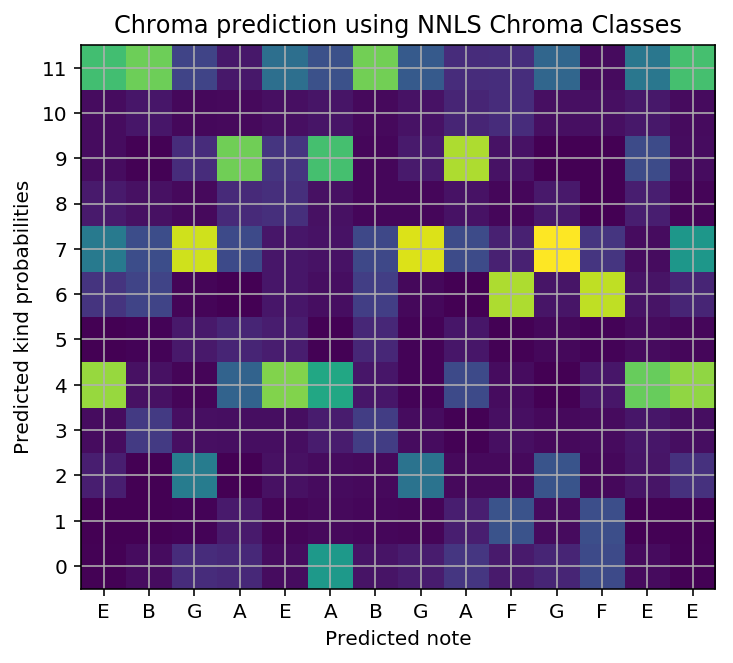

/usr/local/lib/python3.6/site-packages/simmusic-0.4b0-py3.6-linux-x86_64.egg/simmusic/feature_extraction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pool['spectrum.magnitude']), np.array(pool['peaks.frequencies']), np.array(pool['peaks.magnitude'])


Timing precision-> 1.0, recall-> 0.8571428571428571 and f-measure->0.923076923076923


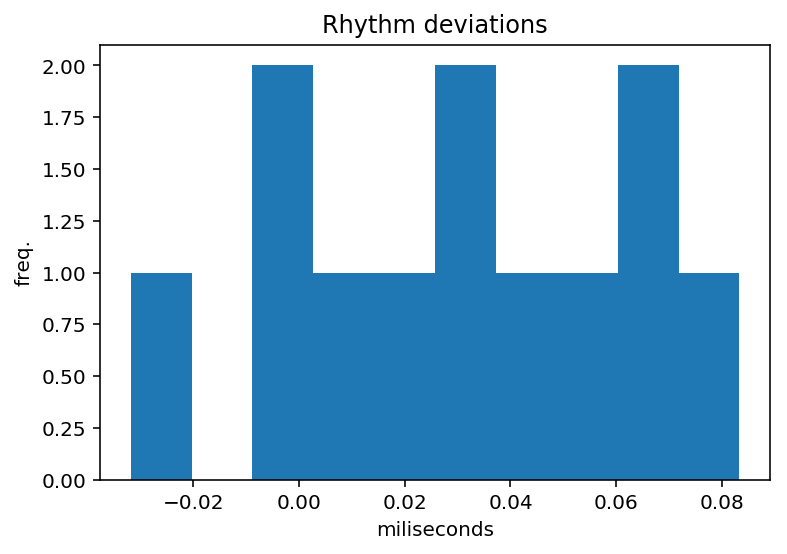

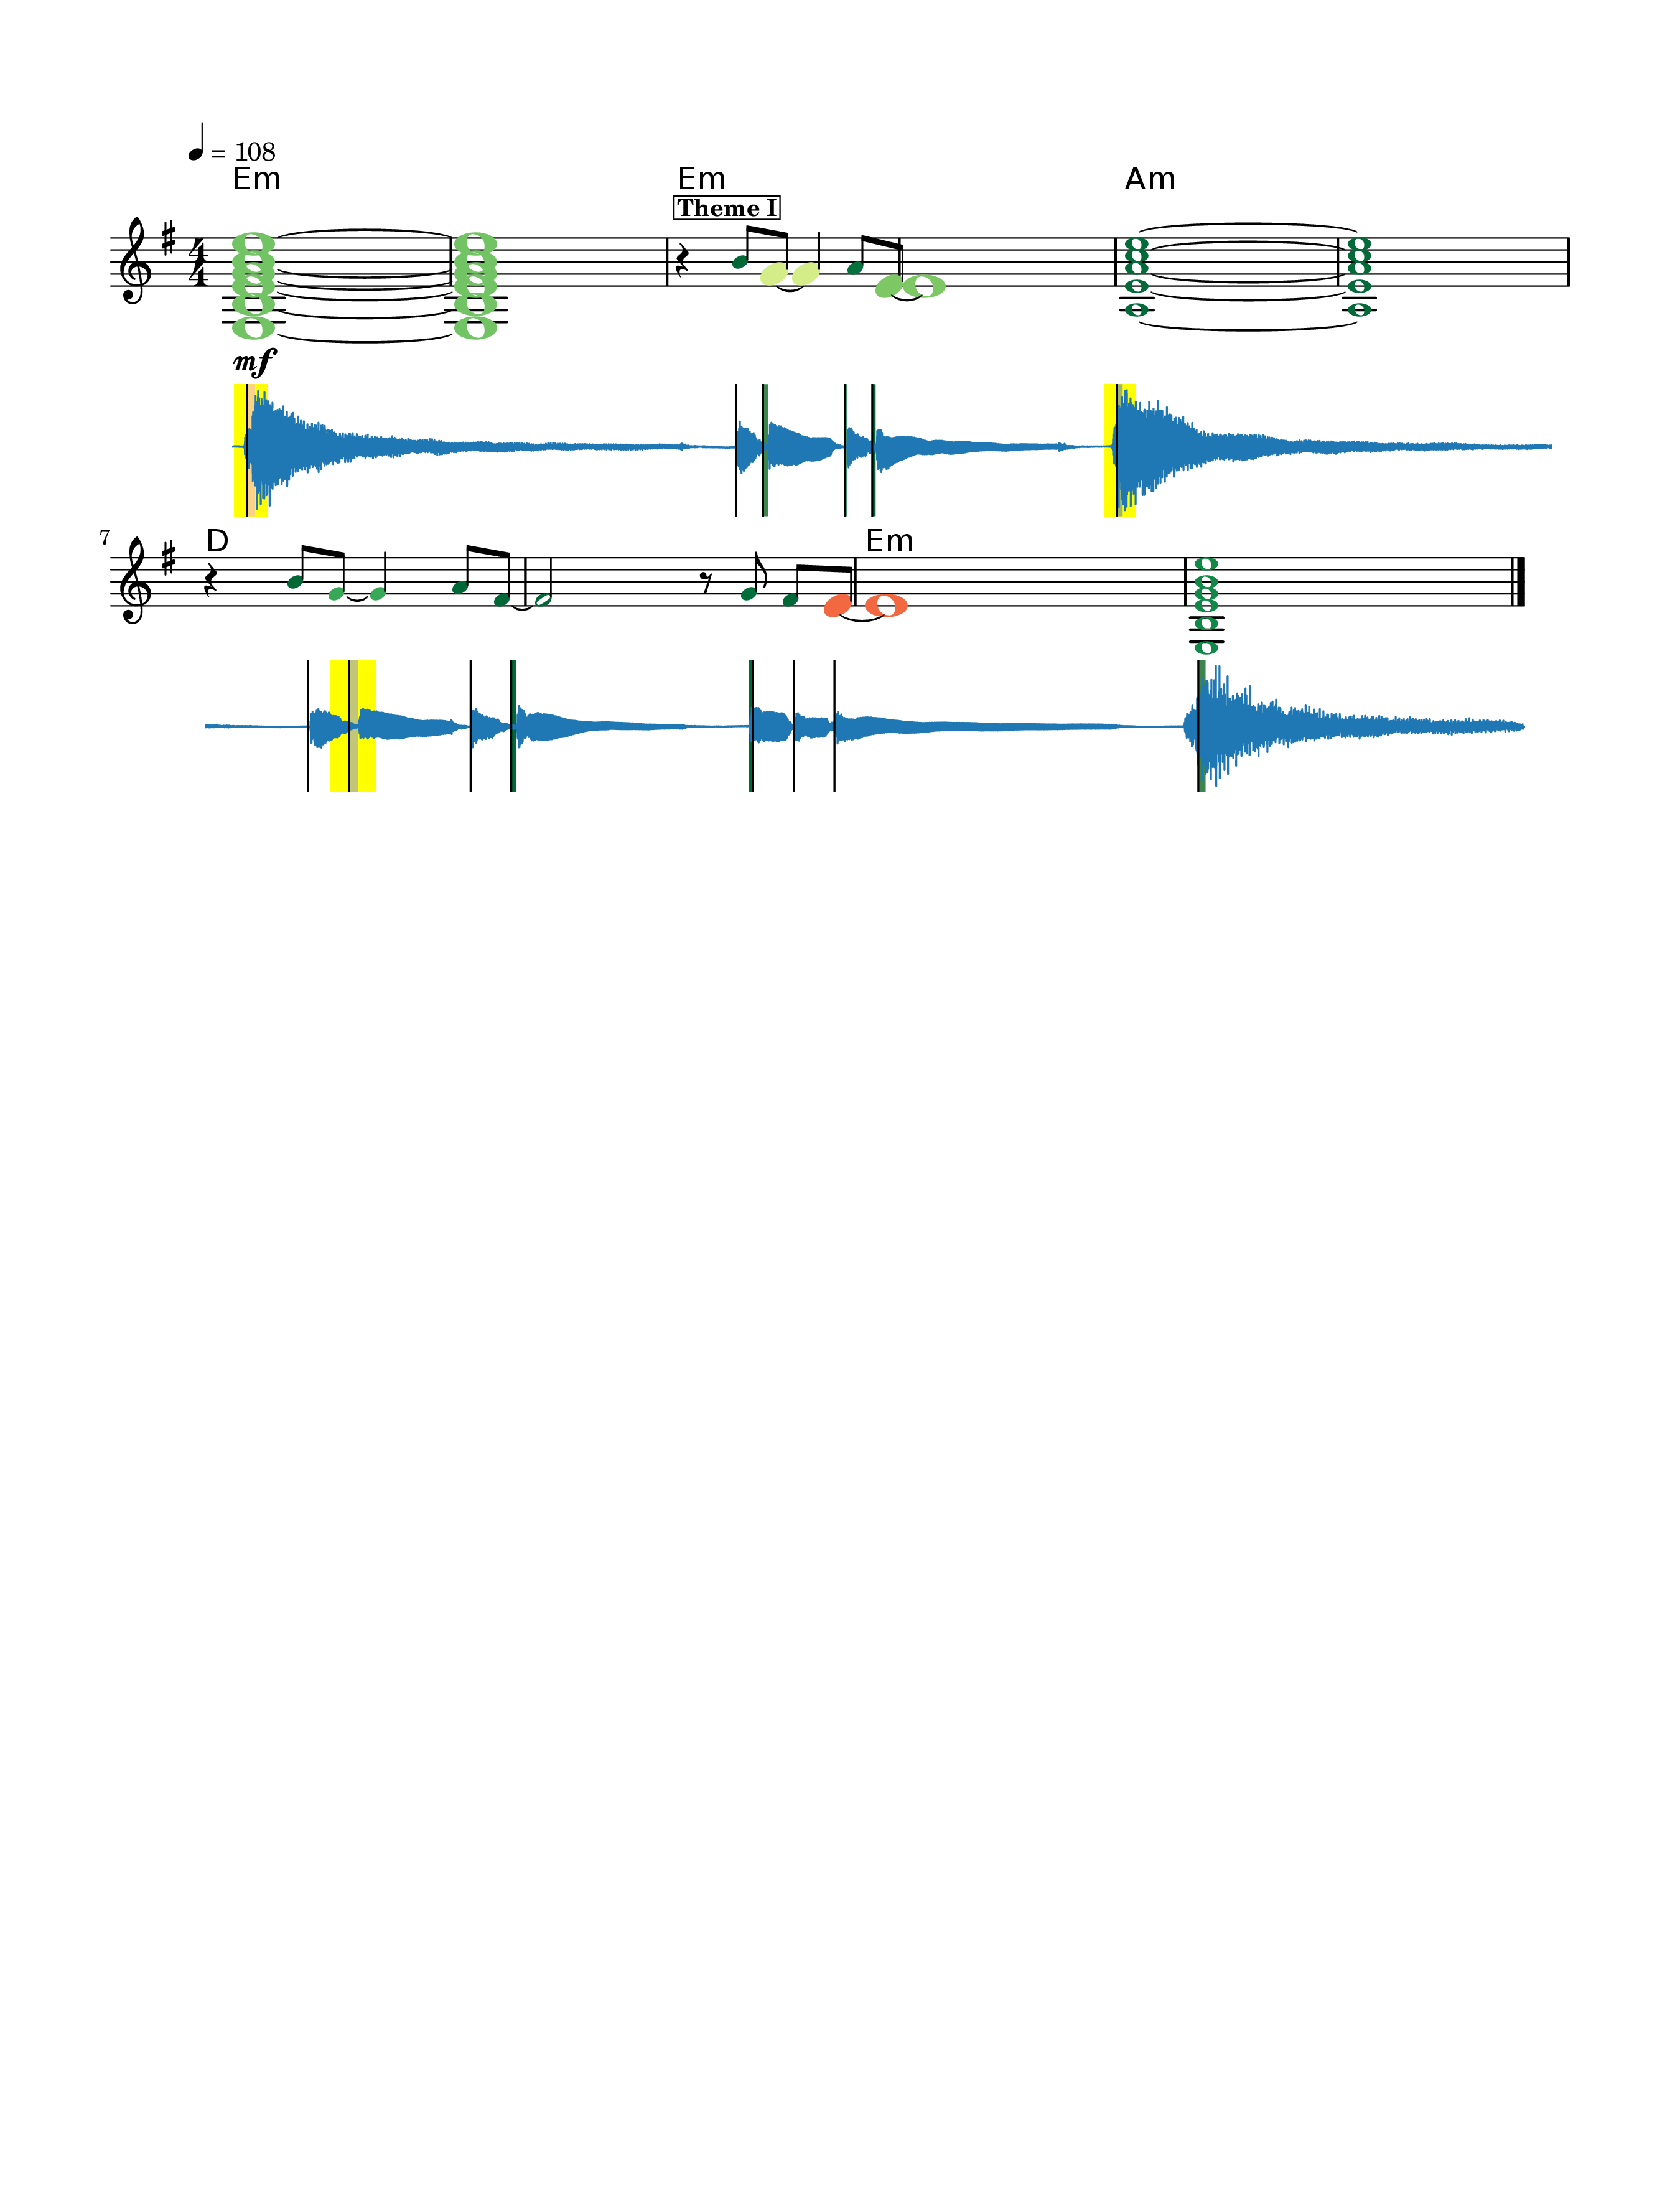

-->Rhythm variation:  0.0001
-->Rhythm skewness:  7.7771
-->Chhroma variation:  0.2218
-->Chhroma skewness:  10.6473
-->Tuning variation:  0.1087
-->Tuning skewness:  3.5353
-----------------------------------------------------------------------
Strumming Grades: Overall, Pitch, Rhythm, Tuning
3.0 2.0 2.0 4.0
PNG is written to Good_performance.png
-----------------------------------------------------------------------


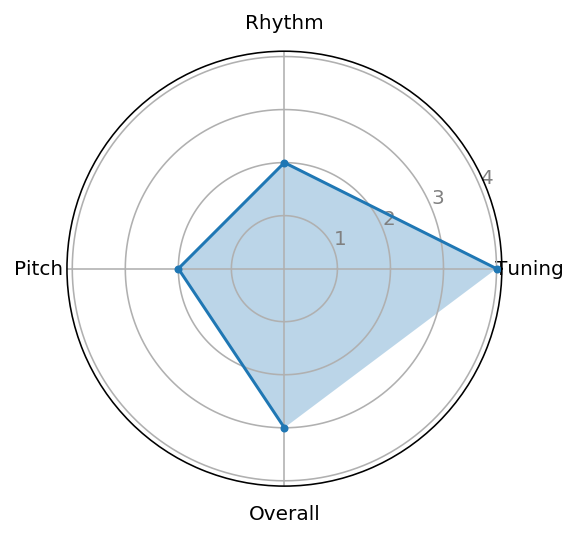

In [69]:
global_results = Assess_Exercise(json,lilypond,target_recording,RESULT_NAME = RESULT_NAME)

/usr/local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


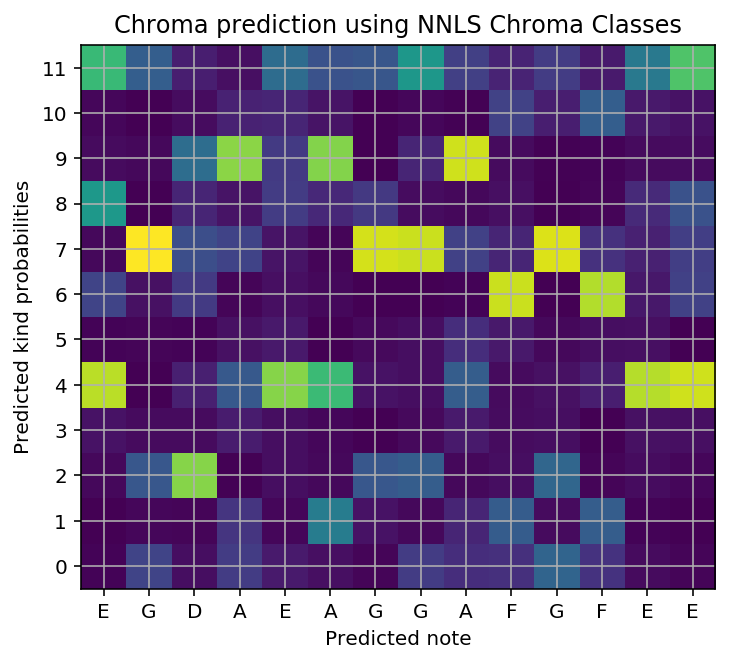

/usr/local/lib/python3.6/site-packages/simmusic-0.4b0-py3.6-linux-x86_64.egg/simmusic/feature_extraction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pool['spectrum.magnitude']), np.array(pool['peaks.frequencies']), np.array(pool['peaks.magnitude'])


Timing precision-> 0.8461538461538461, recall-> 0.7857142857142857 and f-measure->0.8148148148148148


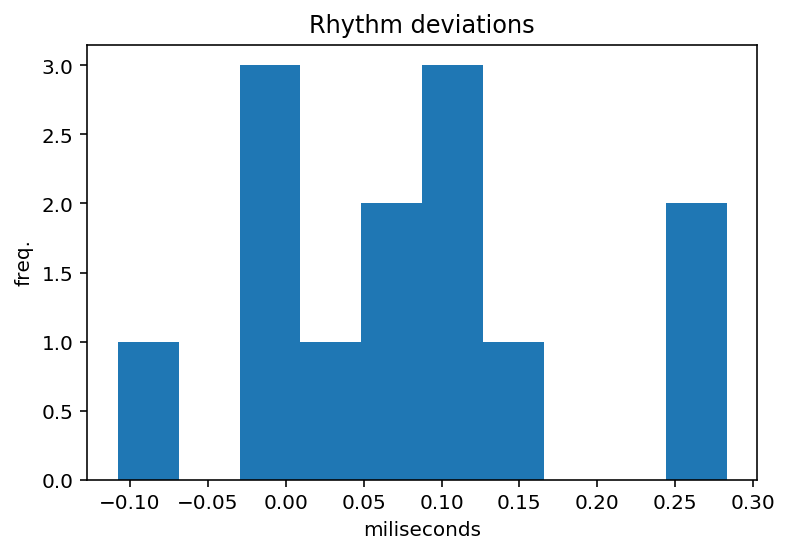

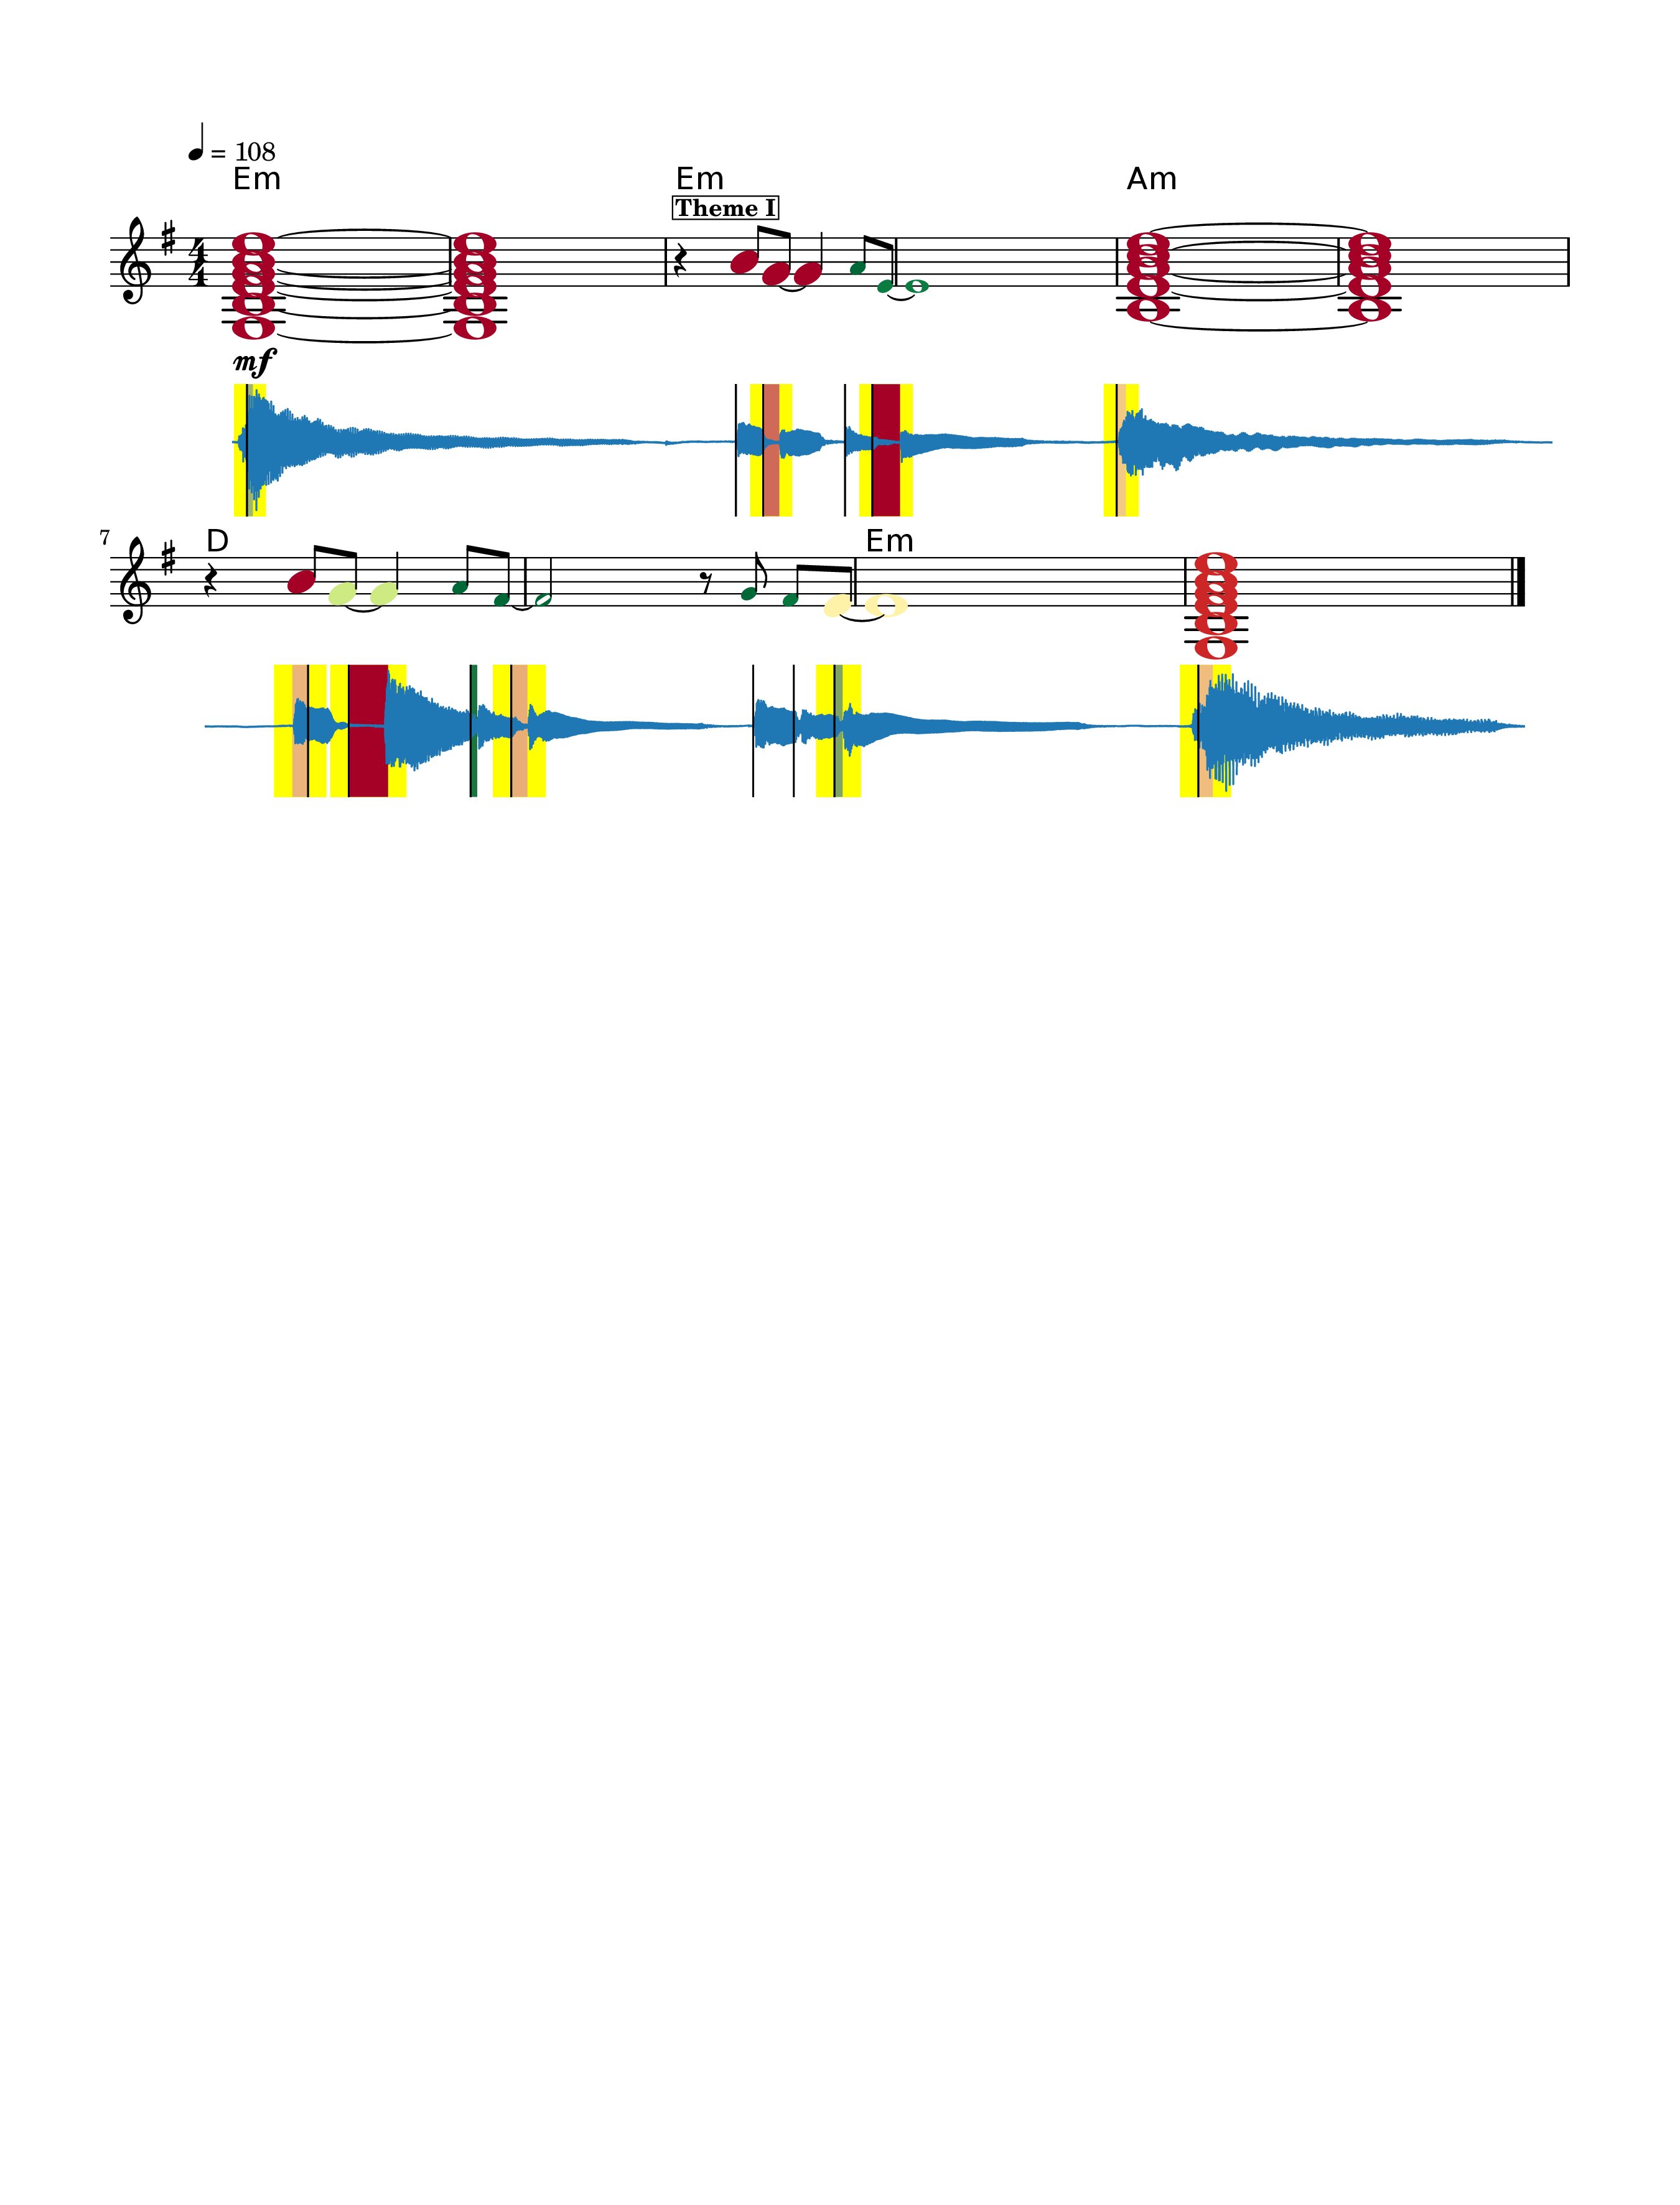

-->Rhythm variation:  0.0098
-->Rhythm skewness:  4.4121
-->Chhroma variation:  171.6362
-->Chhroma skewness:  6.8466
-->Tuning variation:  0.085
-->Tuning skewness:  3.2065
-----------------------------------------------------------------------
Strumming Grades: Overall, Pitch, Rhythm, Tuning
2.0 2.0 2.0 4.0
PNG is written to bad_pitch.png
-----------------------------------------------------------------------


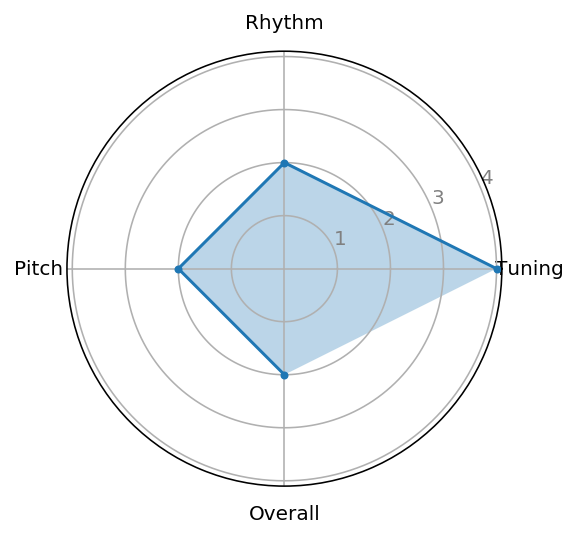

In [70]:
target_recording = data_path +'bad_pitch.wav'
RESULT_NAME = 'bad_pitch'
global_results = Assess_Exercise(json,lilypond,target_recording,RESULT_NAME = RESULT_NAME)

/usr/local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


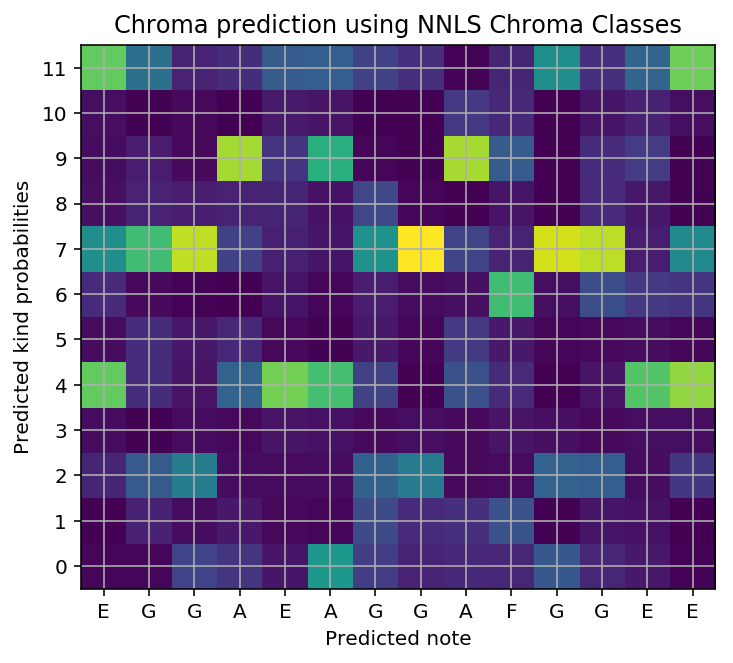

/usr/local/lib/python3.6/site-packages/simmusic-0.4b0-py3.6-linux-x86_64.egg/simmusic/feature_extraction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pool['spectrum.magnitude']), np.array(pool['peaks.frequencies']), np.array(pool['peaks.magnitude'])


Timing precision-> 0.5714285714285714, recall-> 0.5714285714285714 and f-measure->0.5714285714285714


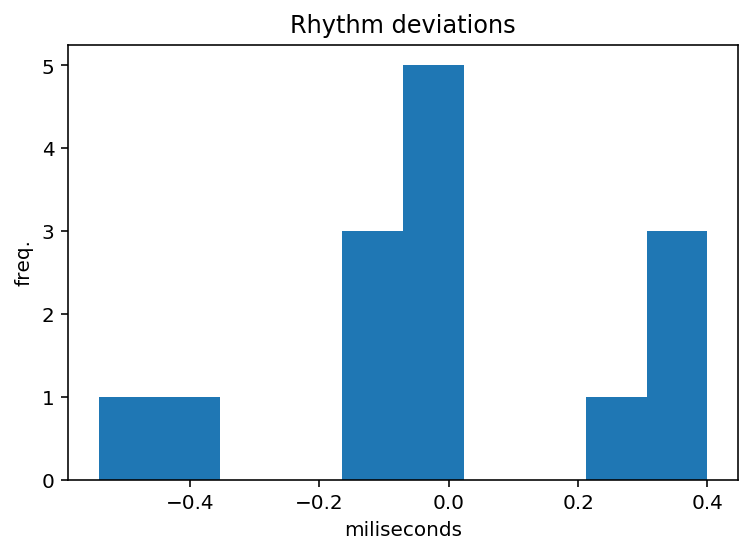

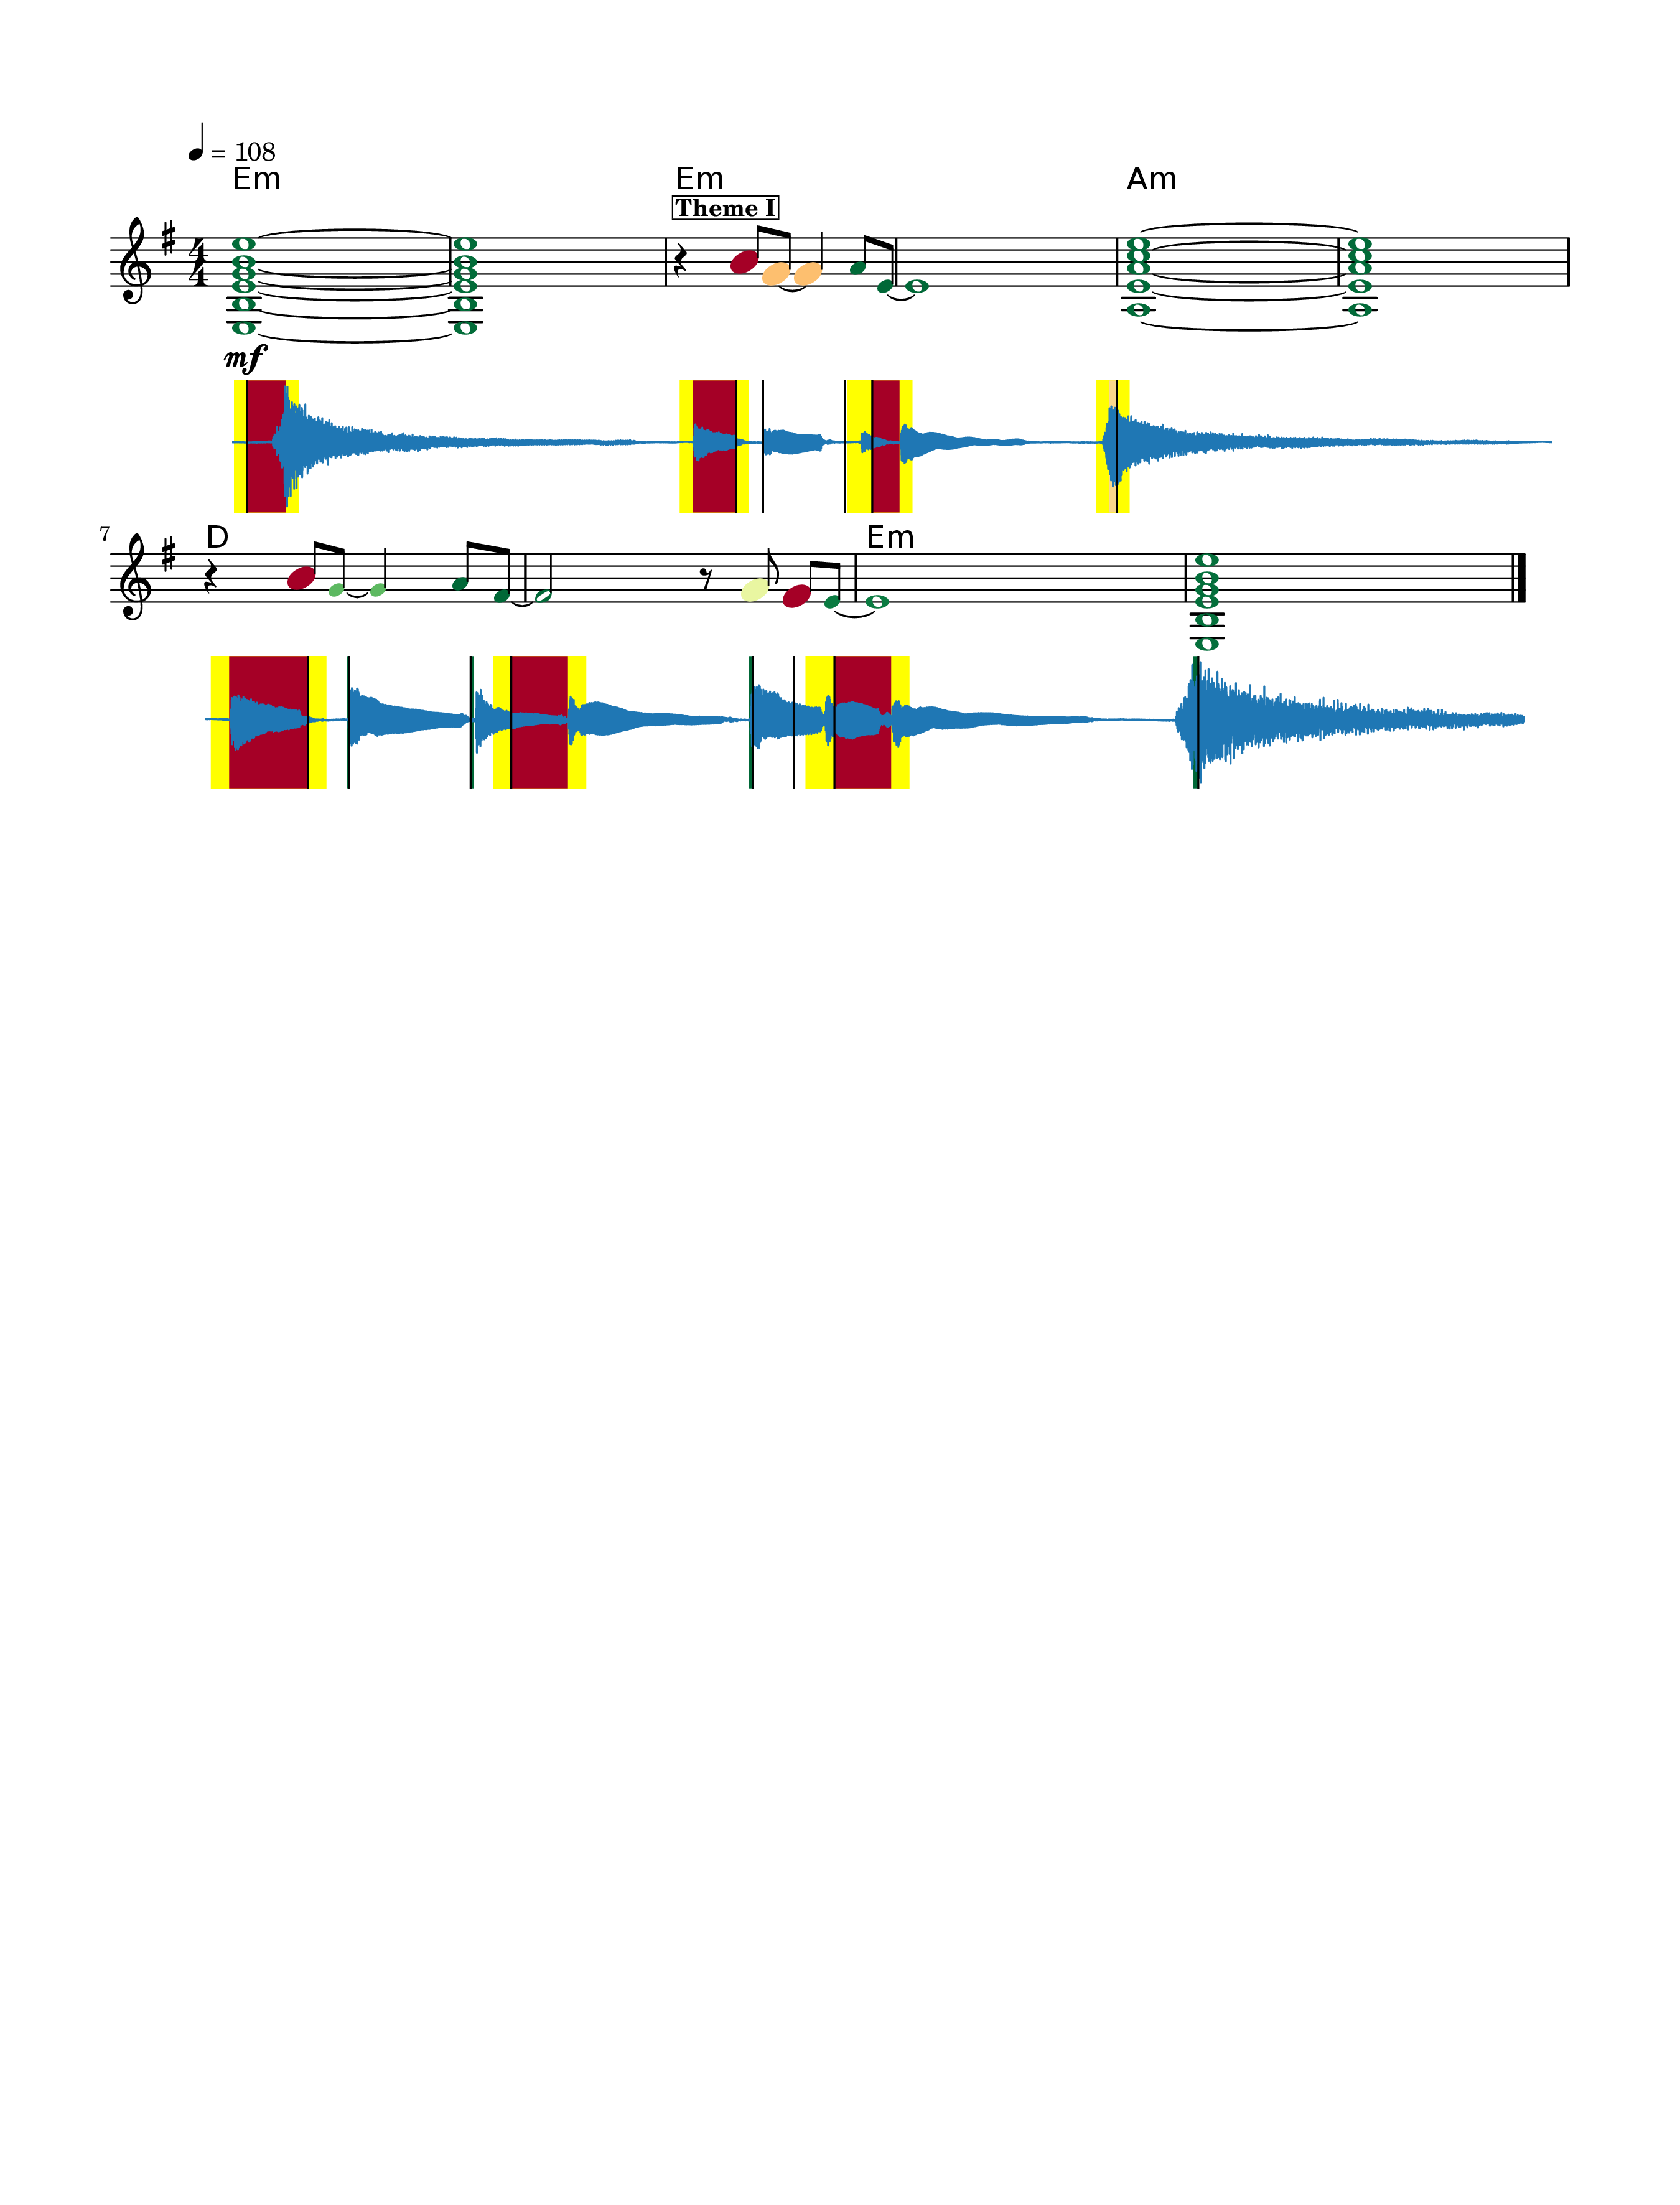

-->Rhythm variation:  0.0575
-->Rhythm skewness:  2.7174
-->Chhroma variation:  49.2993
-->Chhroma skewness:  5.2097
-->Tuning variation:  0.1116
-->Tuning skewness:  3.268
-----------------------------------------------------------------------
Strumming Grades: Overall, Pitch, Rhythm, Tuning
2.0 2.0 2.0 4.0
PNG is written to bad_tempo.png
-----------------------------------------------------------------------


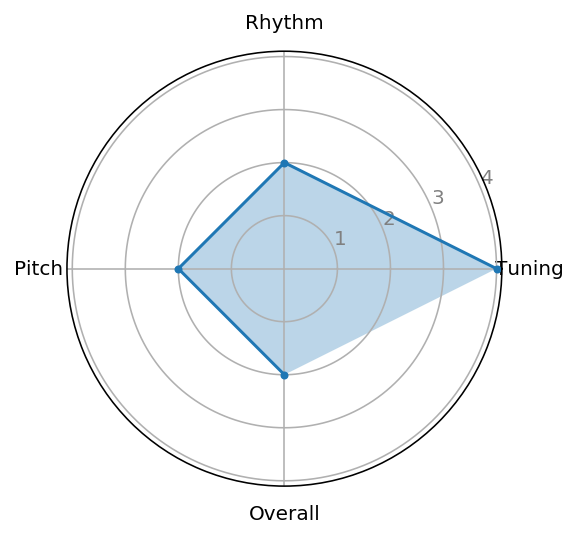

In [71]:
target_recording = data_path +'bad_tempo.wav'
RESULT_NAME = 'bad_tempo'
global_results = Assess_Exercise(json,lilypond,target_recording,RESULT_NAME = RESULT_NAME)

/usr/local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


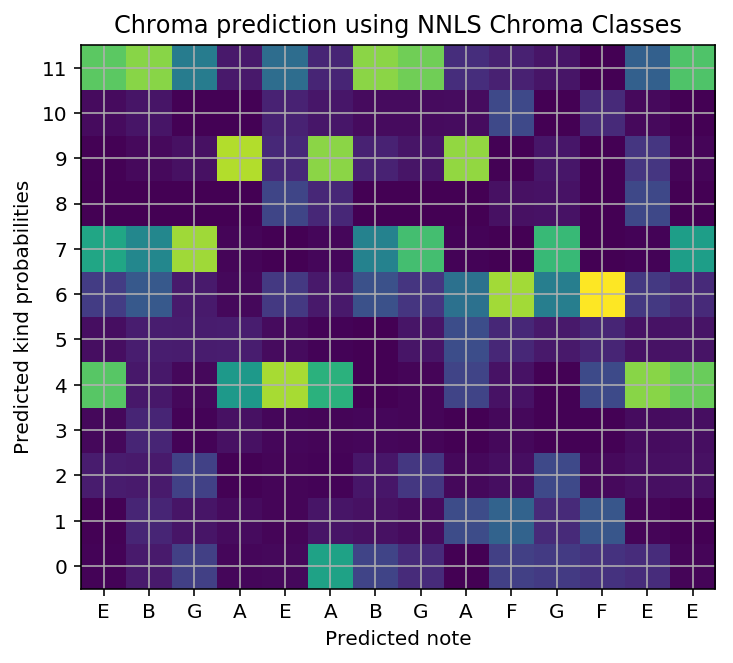

/usr/local/lib/python3.6/site-packages/simmusic-0.4b0-py3.6-linux-x86_64.egg/simmusic/feature_extraction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pool['spectrum.magnitude']), np.array(pool['peaks.frequencies']), np.array(pool['peaks.magnitude'])


Timing precision-> 0.875, recall-> 1.0 and f-measure->0.9333333333333333


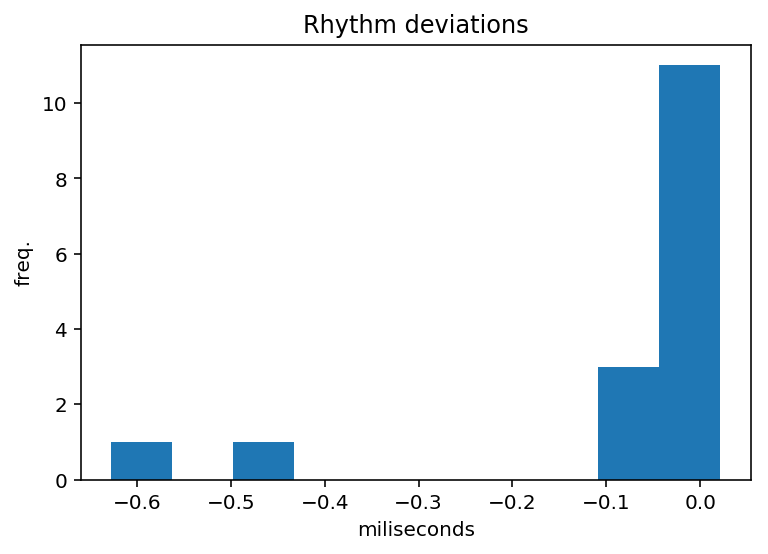

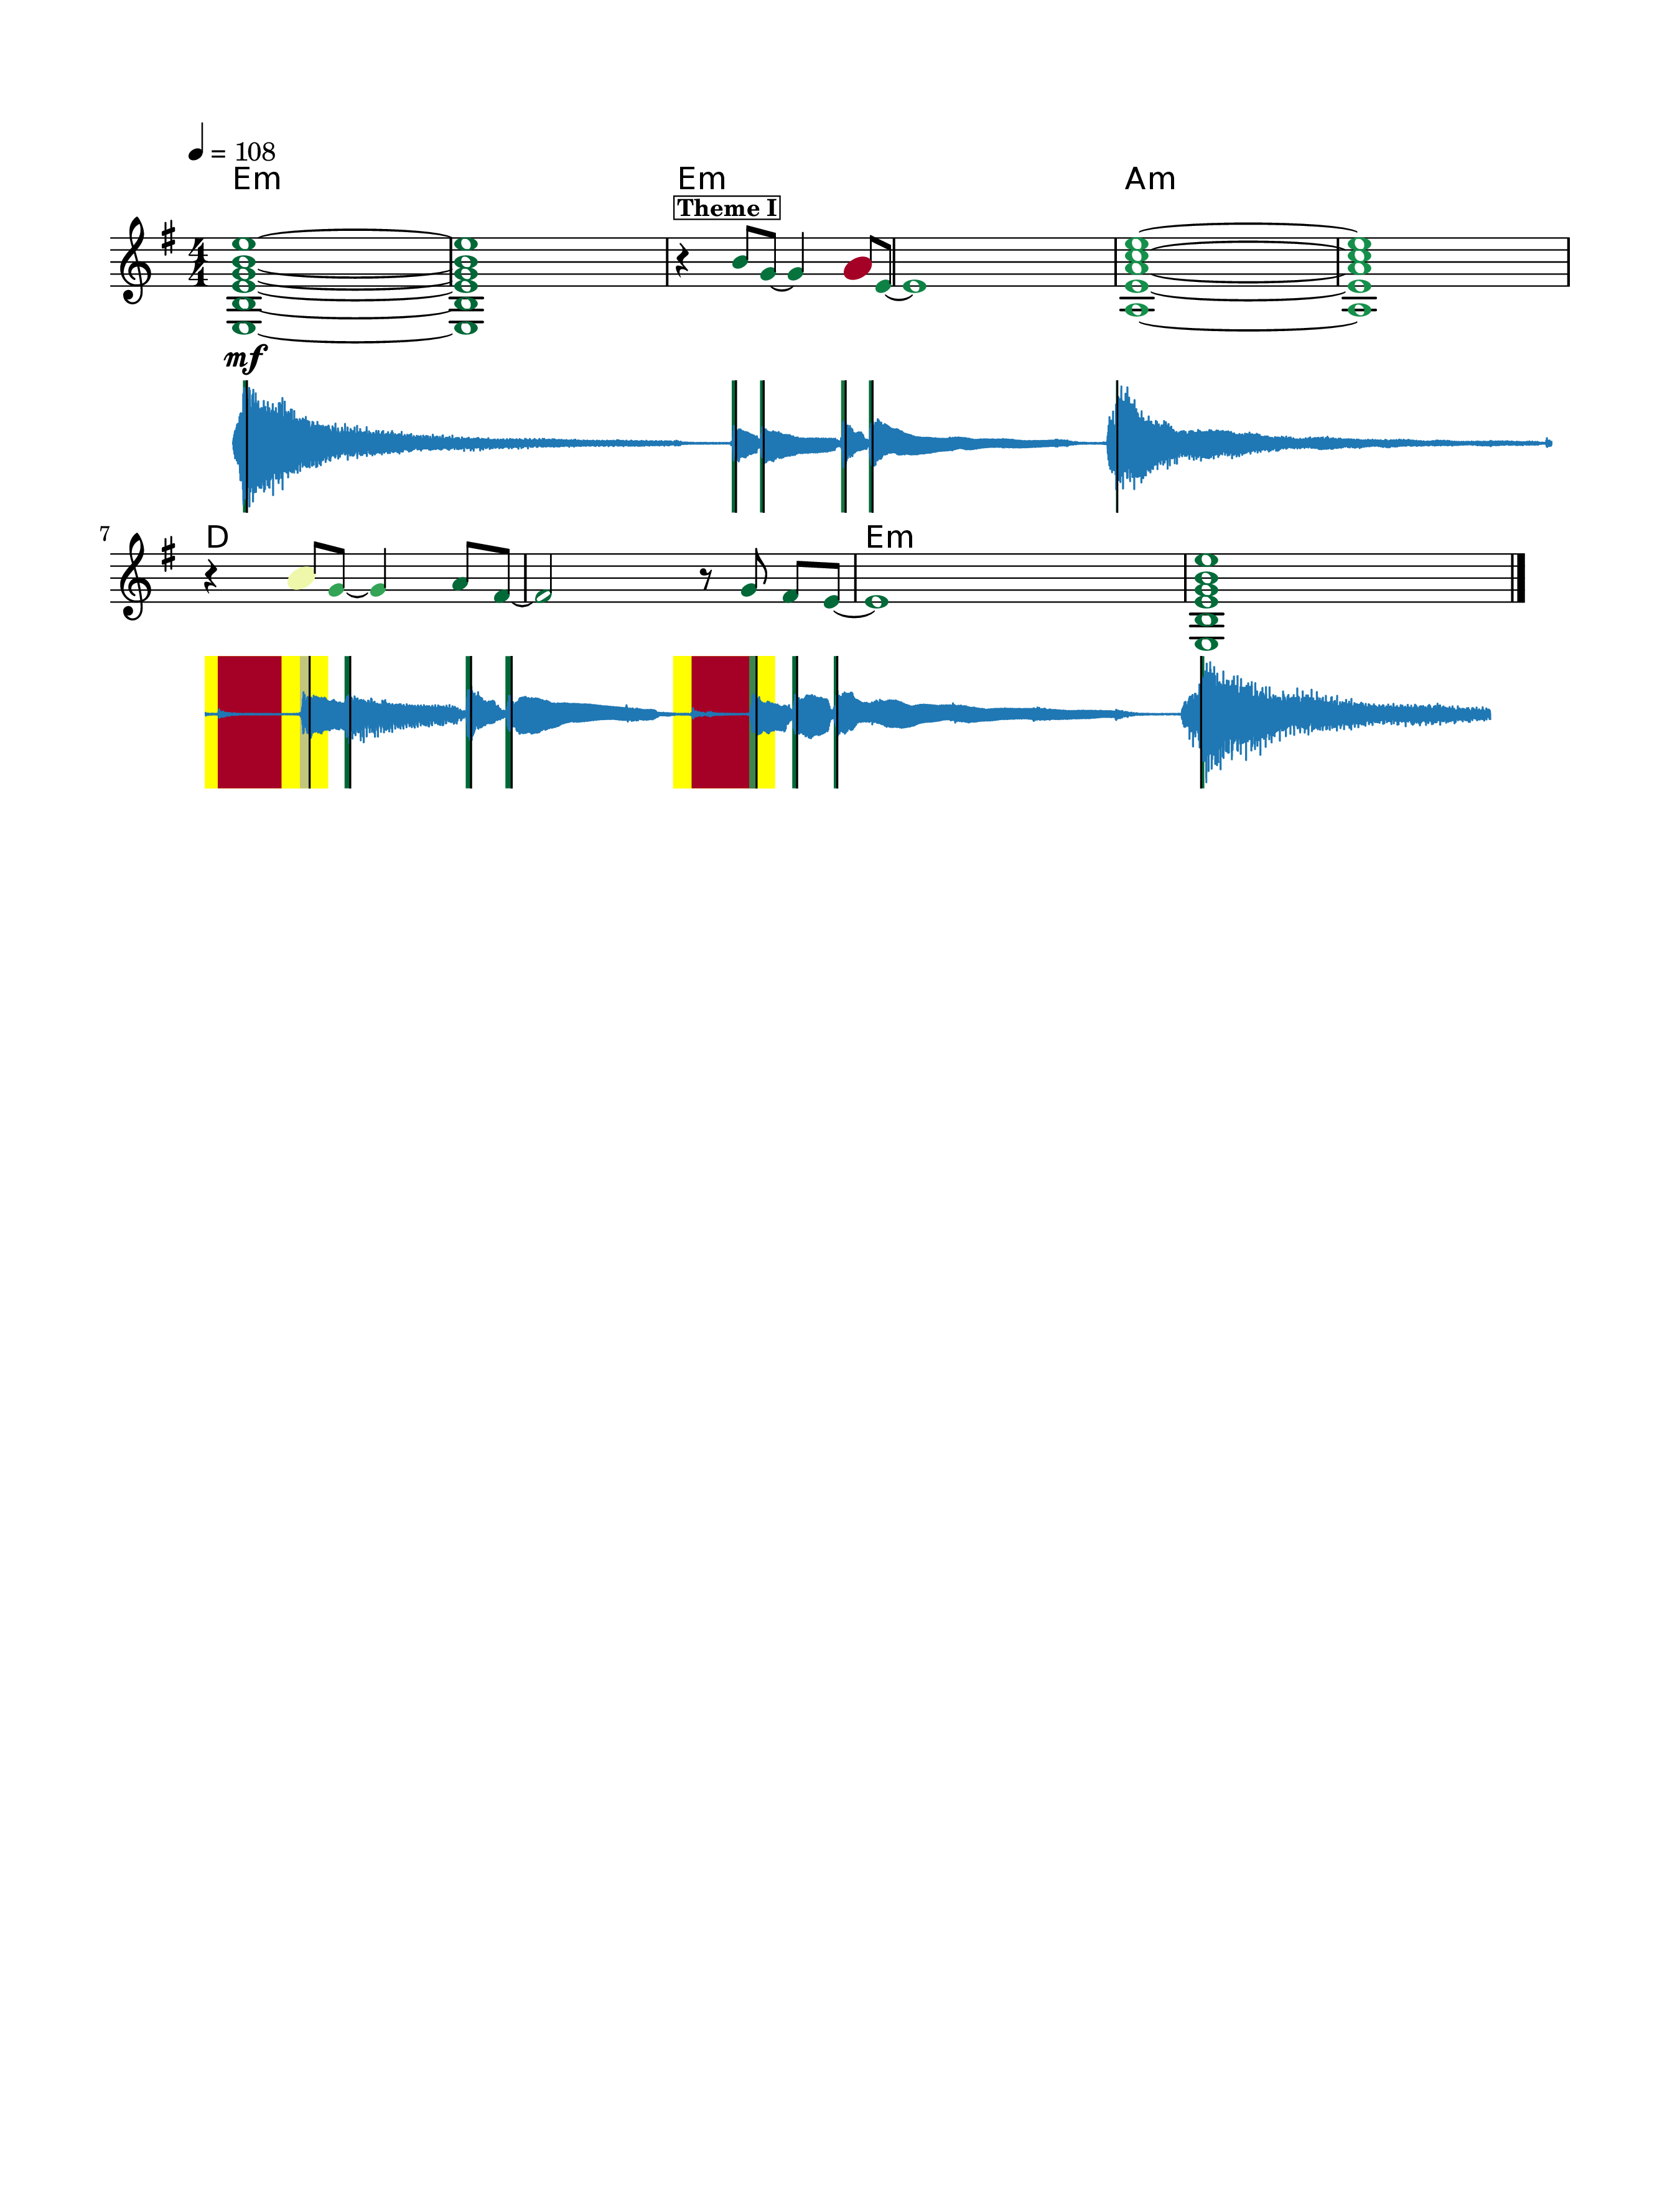

-->Rhythm variation:  0.0305
-->Rhythm skewness:  9.0486
-->Chhroma variation:  2.8821
-->Chhroma skewness:  13.7196
-->Tuning variation:  0.0551
-->Tuning skewness:  4.823
-----------------------------------------------------------------------
Strumming Grades: Overall, Pitch, Rhythm, Tuning
3.0 2.0 2.0 4.0
PNG is written to noise.png
-----------------------------------------------------------------------


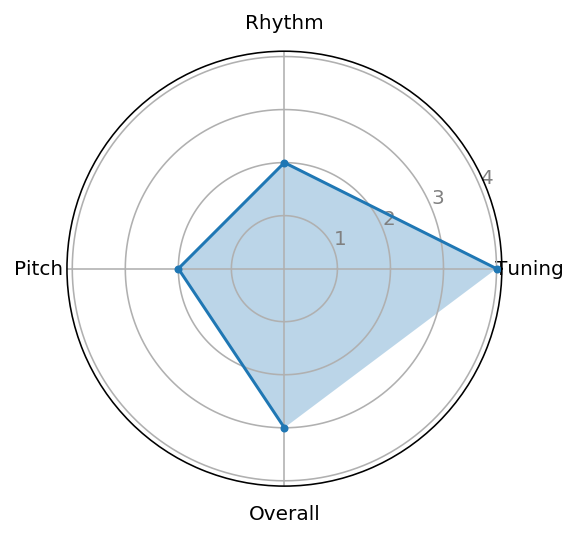

In [73]:
#Noise examplee!!!!!!
json = data_path + 'lily_was_here_old.json'
target_recording = data_path +'noise.wav'
RESULT_NAME = 'noise'
global_results = Assess_Exercise(json,lilypond,target_recording,RESULT_NAME = RESULT_NAME)

/usr/local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


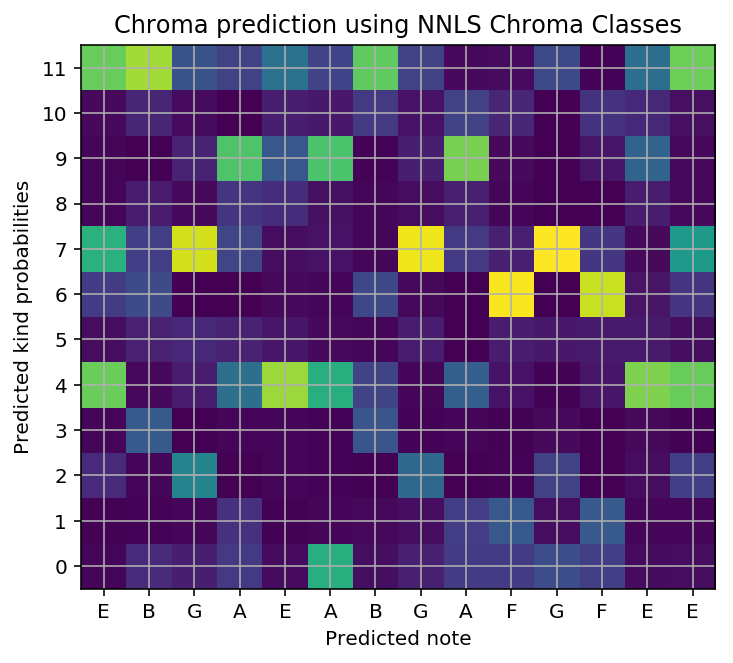

/usr/local/lib/python3.6/site-packages/simmusic-0.4b0-py3.6-linux-x86_64.egg/simmusic/feature_extraction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pool['spectrum.magnitude']), np.array(pool['peaks.frequencies']), np.array(pool['peaks.magnitude'])


Timing precision-> 1.0, recall-> 0.7857142857142857 and f-measure->0.88


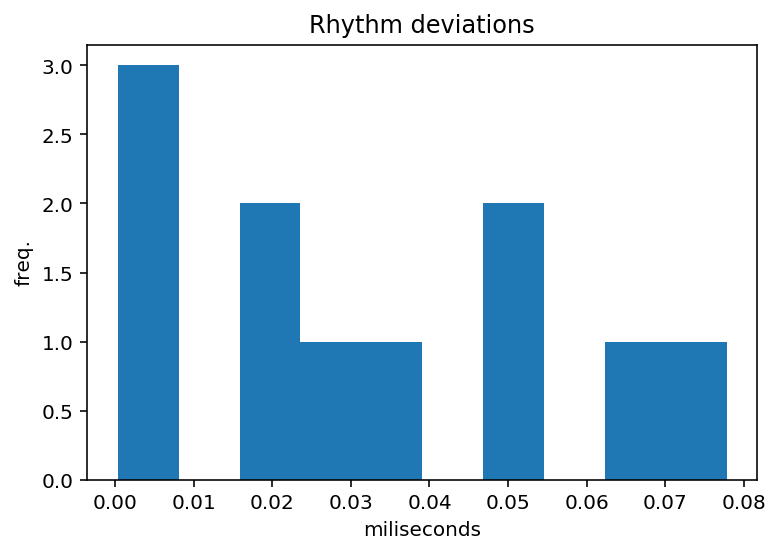

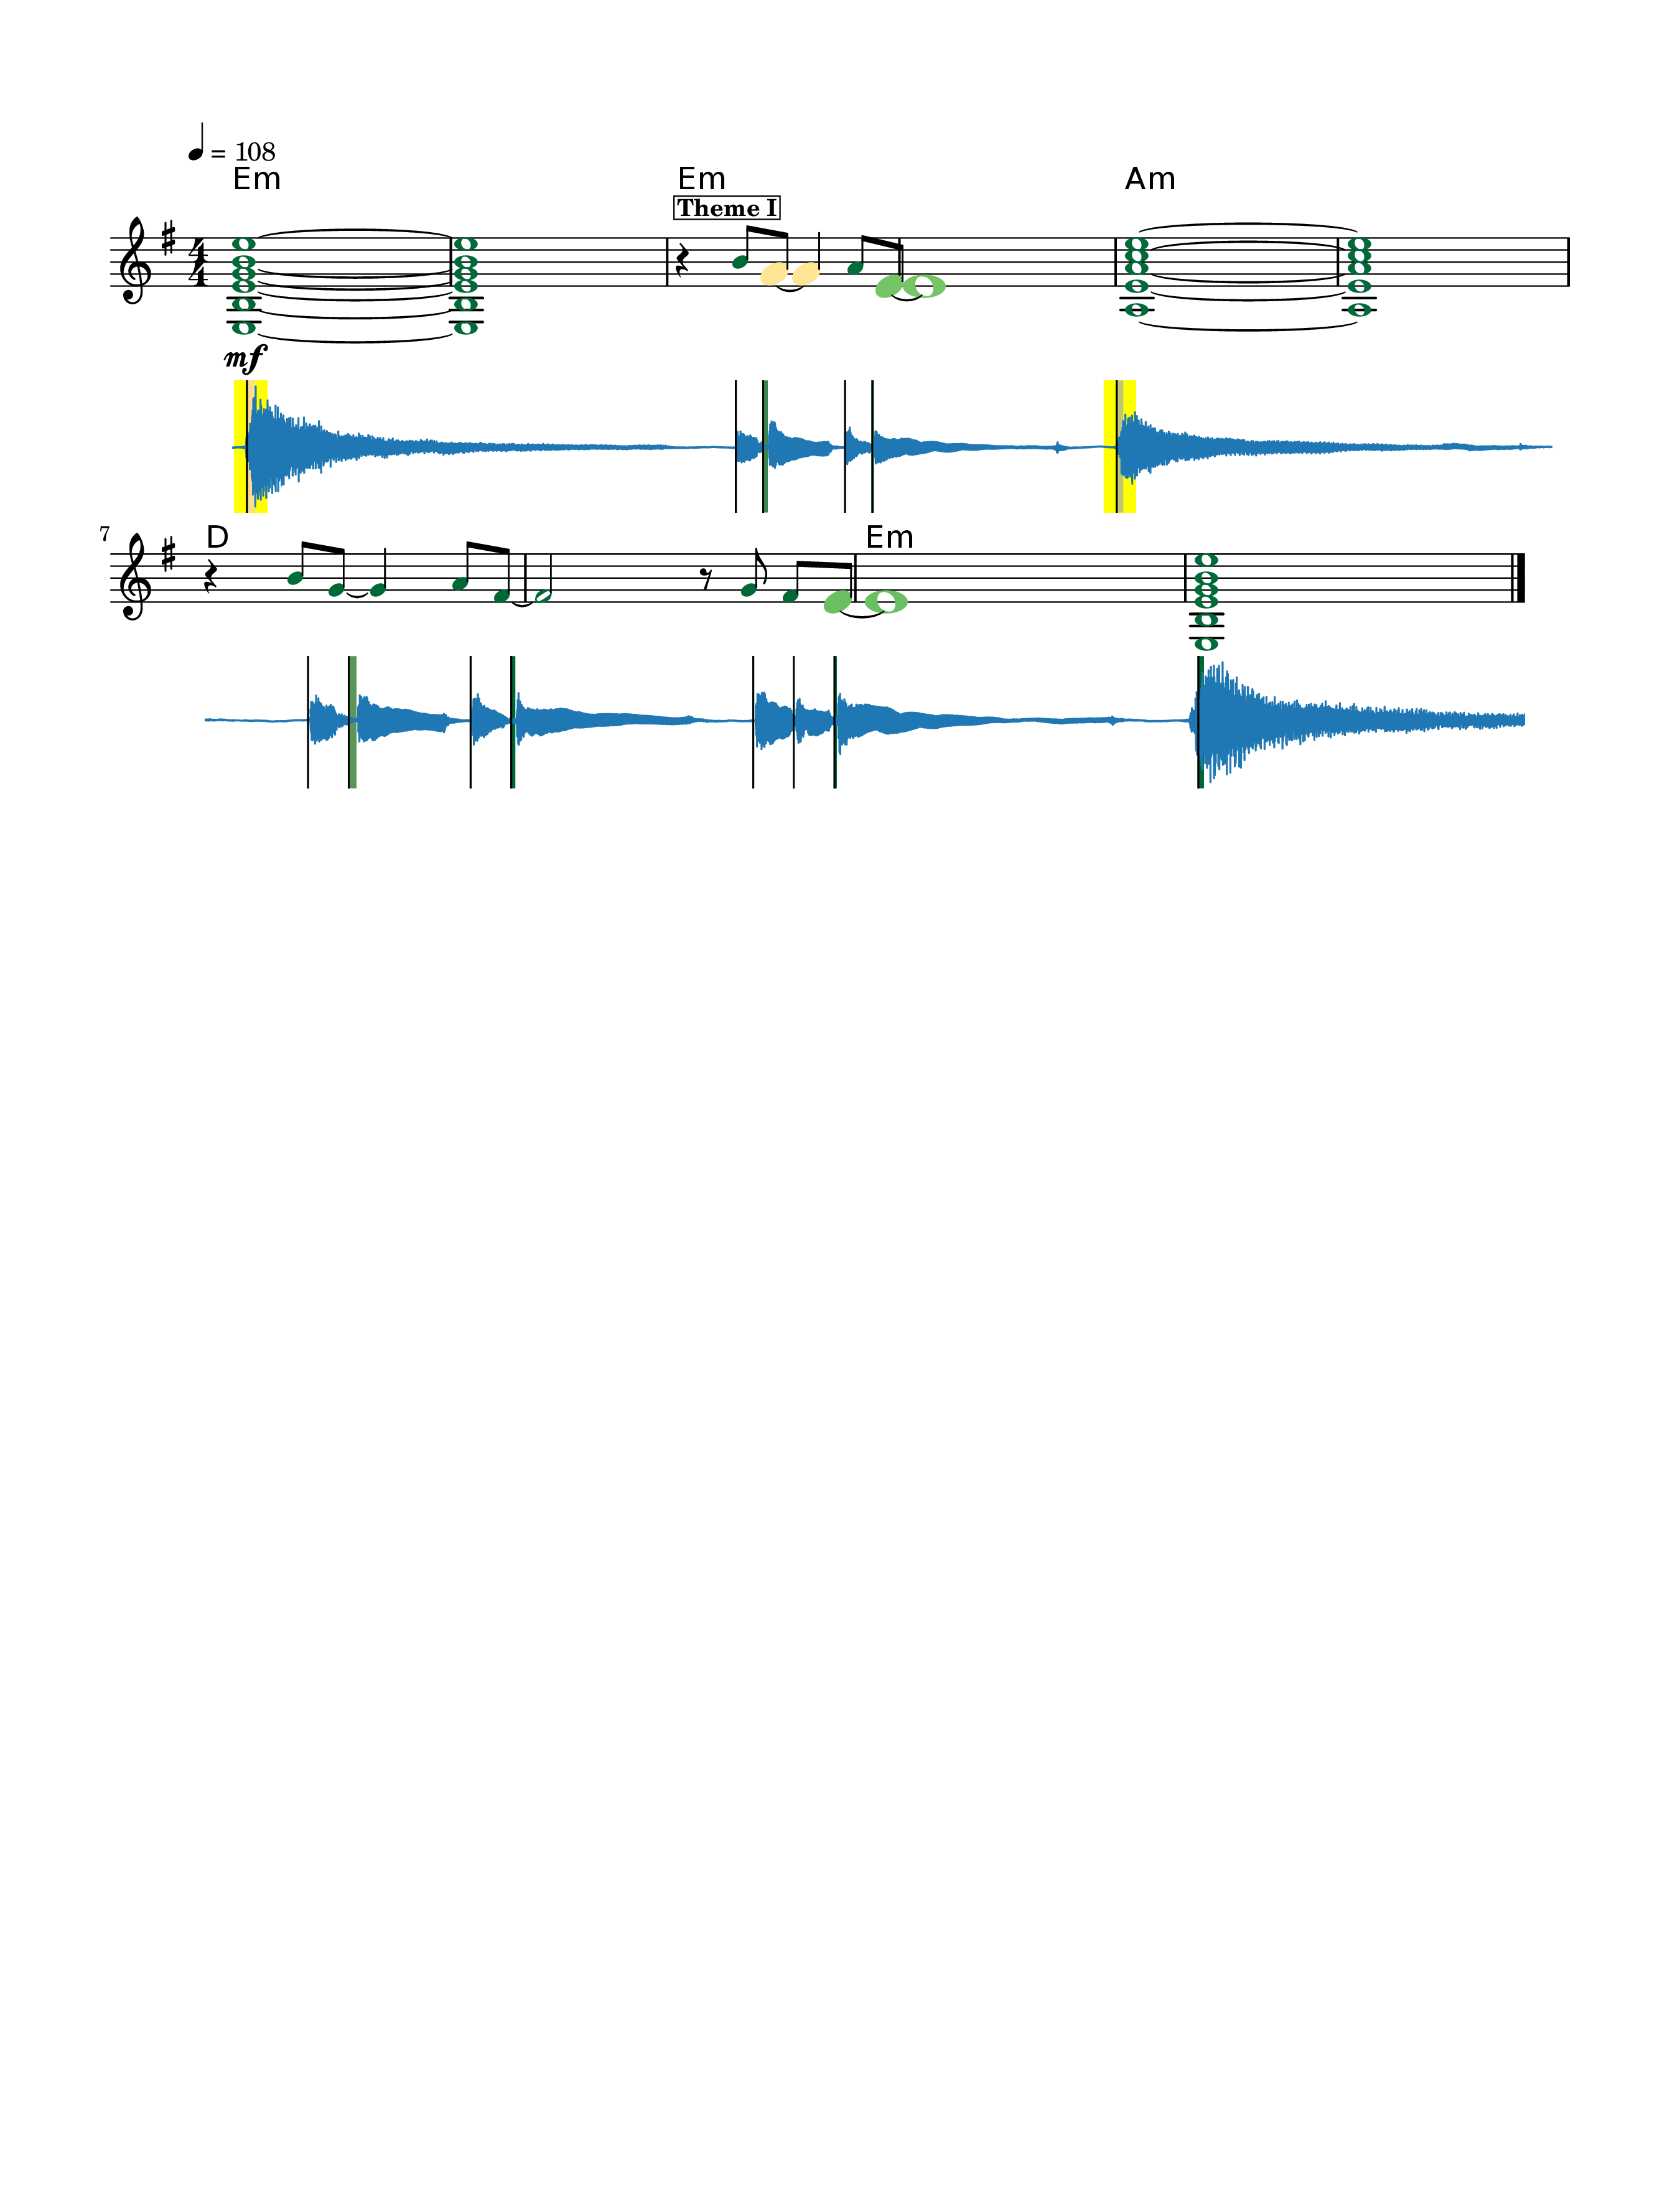

-->Rhythm variation:  0.0001
-->Rhythm skewness:  6.8285
-->Chhroma variation:  0.0627
-->Chhroma skewness:  10.5181
-->Tuning variation:  0.0937
-->Tuning skewness:  4.0122
-----------------------------------------------------------------------
Strumming Grades: Overall, Pitch, Rhythm, Tuning
3.0 2.0 2.0 4.0
PNG is written to Acustic_mono.png
-----------------------------------------------------------------------


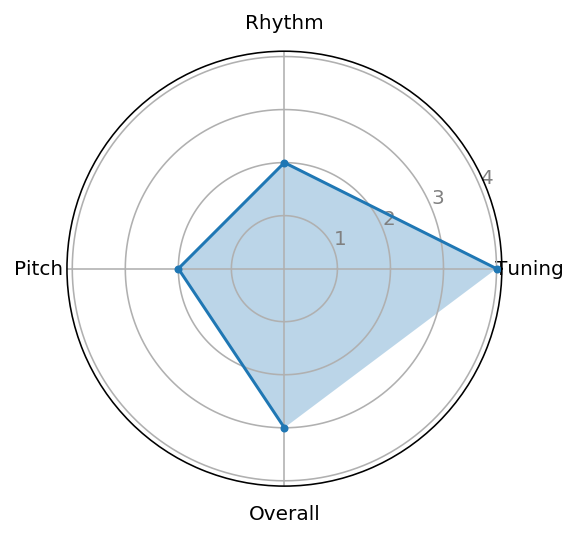

In [74]:
#Mono vs Stereo
#---------------Mono-----------
json = data_path + 'lily_was_here.json'
target_recording = data_path +'Acustic_mono.wav'
RESULT_NAME = 'Acustic_mono'
global_results = Assess_Exercise(json,lilypond,target_recording,RESULT_NAME = RESULT_NAME)

/usr/local/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.21.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


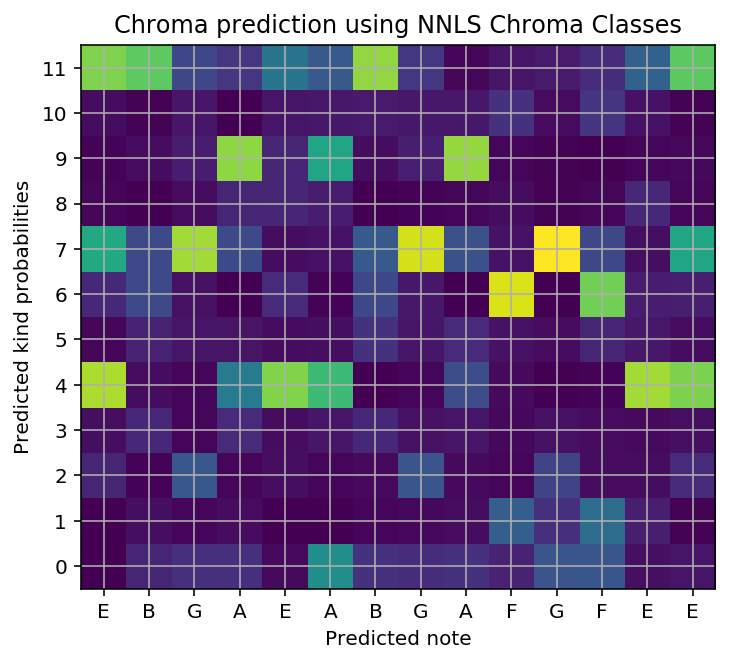

/usr/local/lib/python3.6/site-packages/simmusic-0.4b0-py3.6-linux-x86_64.egg/simmusic/feature_extraction.py:538: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(pool['spectrum.magnitude']), np.array(pool['peaks.frequencies']), np.array(pool['peaks.magnitude'])


Timing precision-> 1.0, recall-> 1.0 and f-measure->1.0


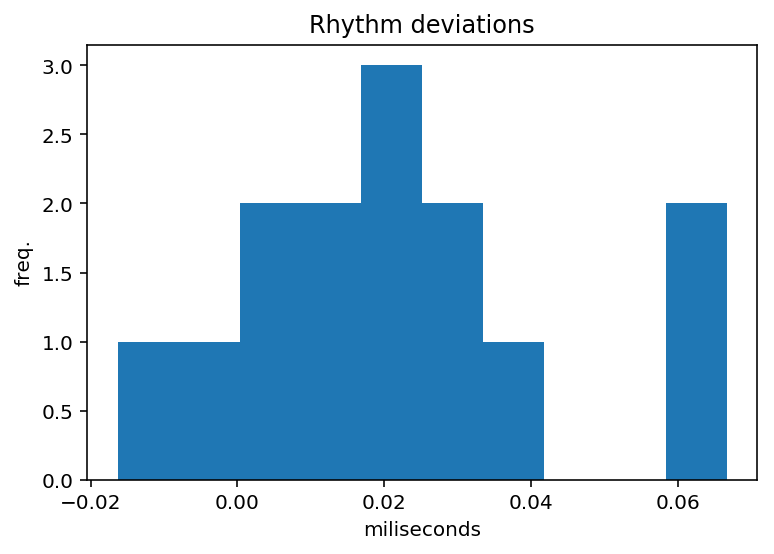

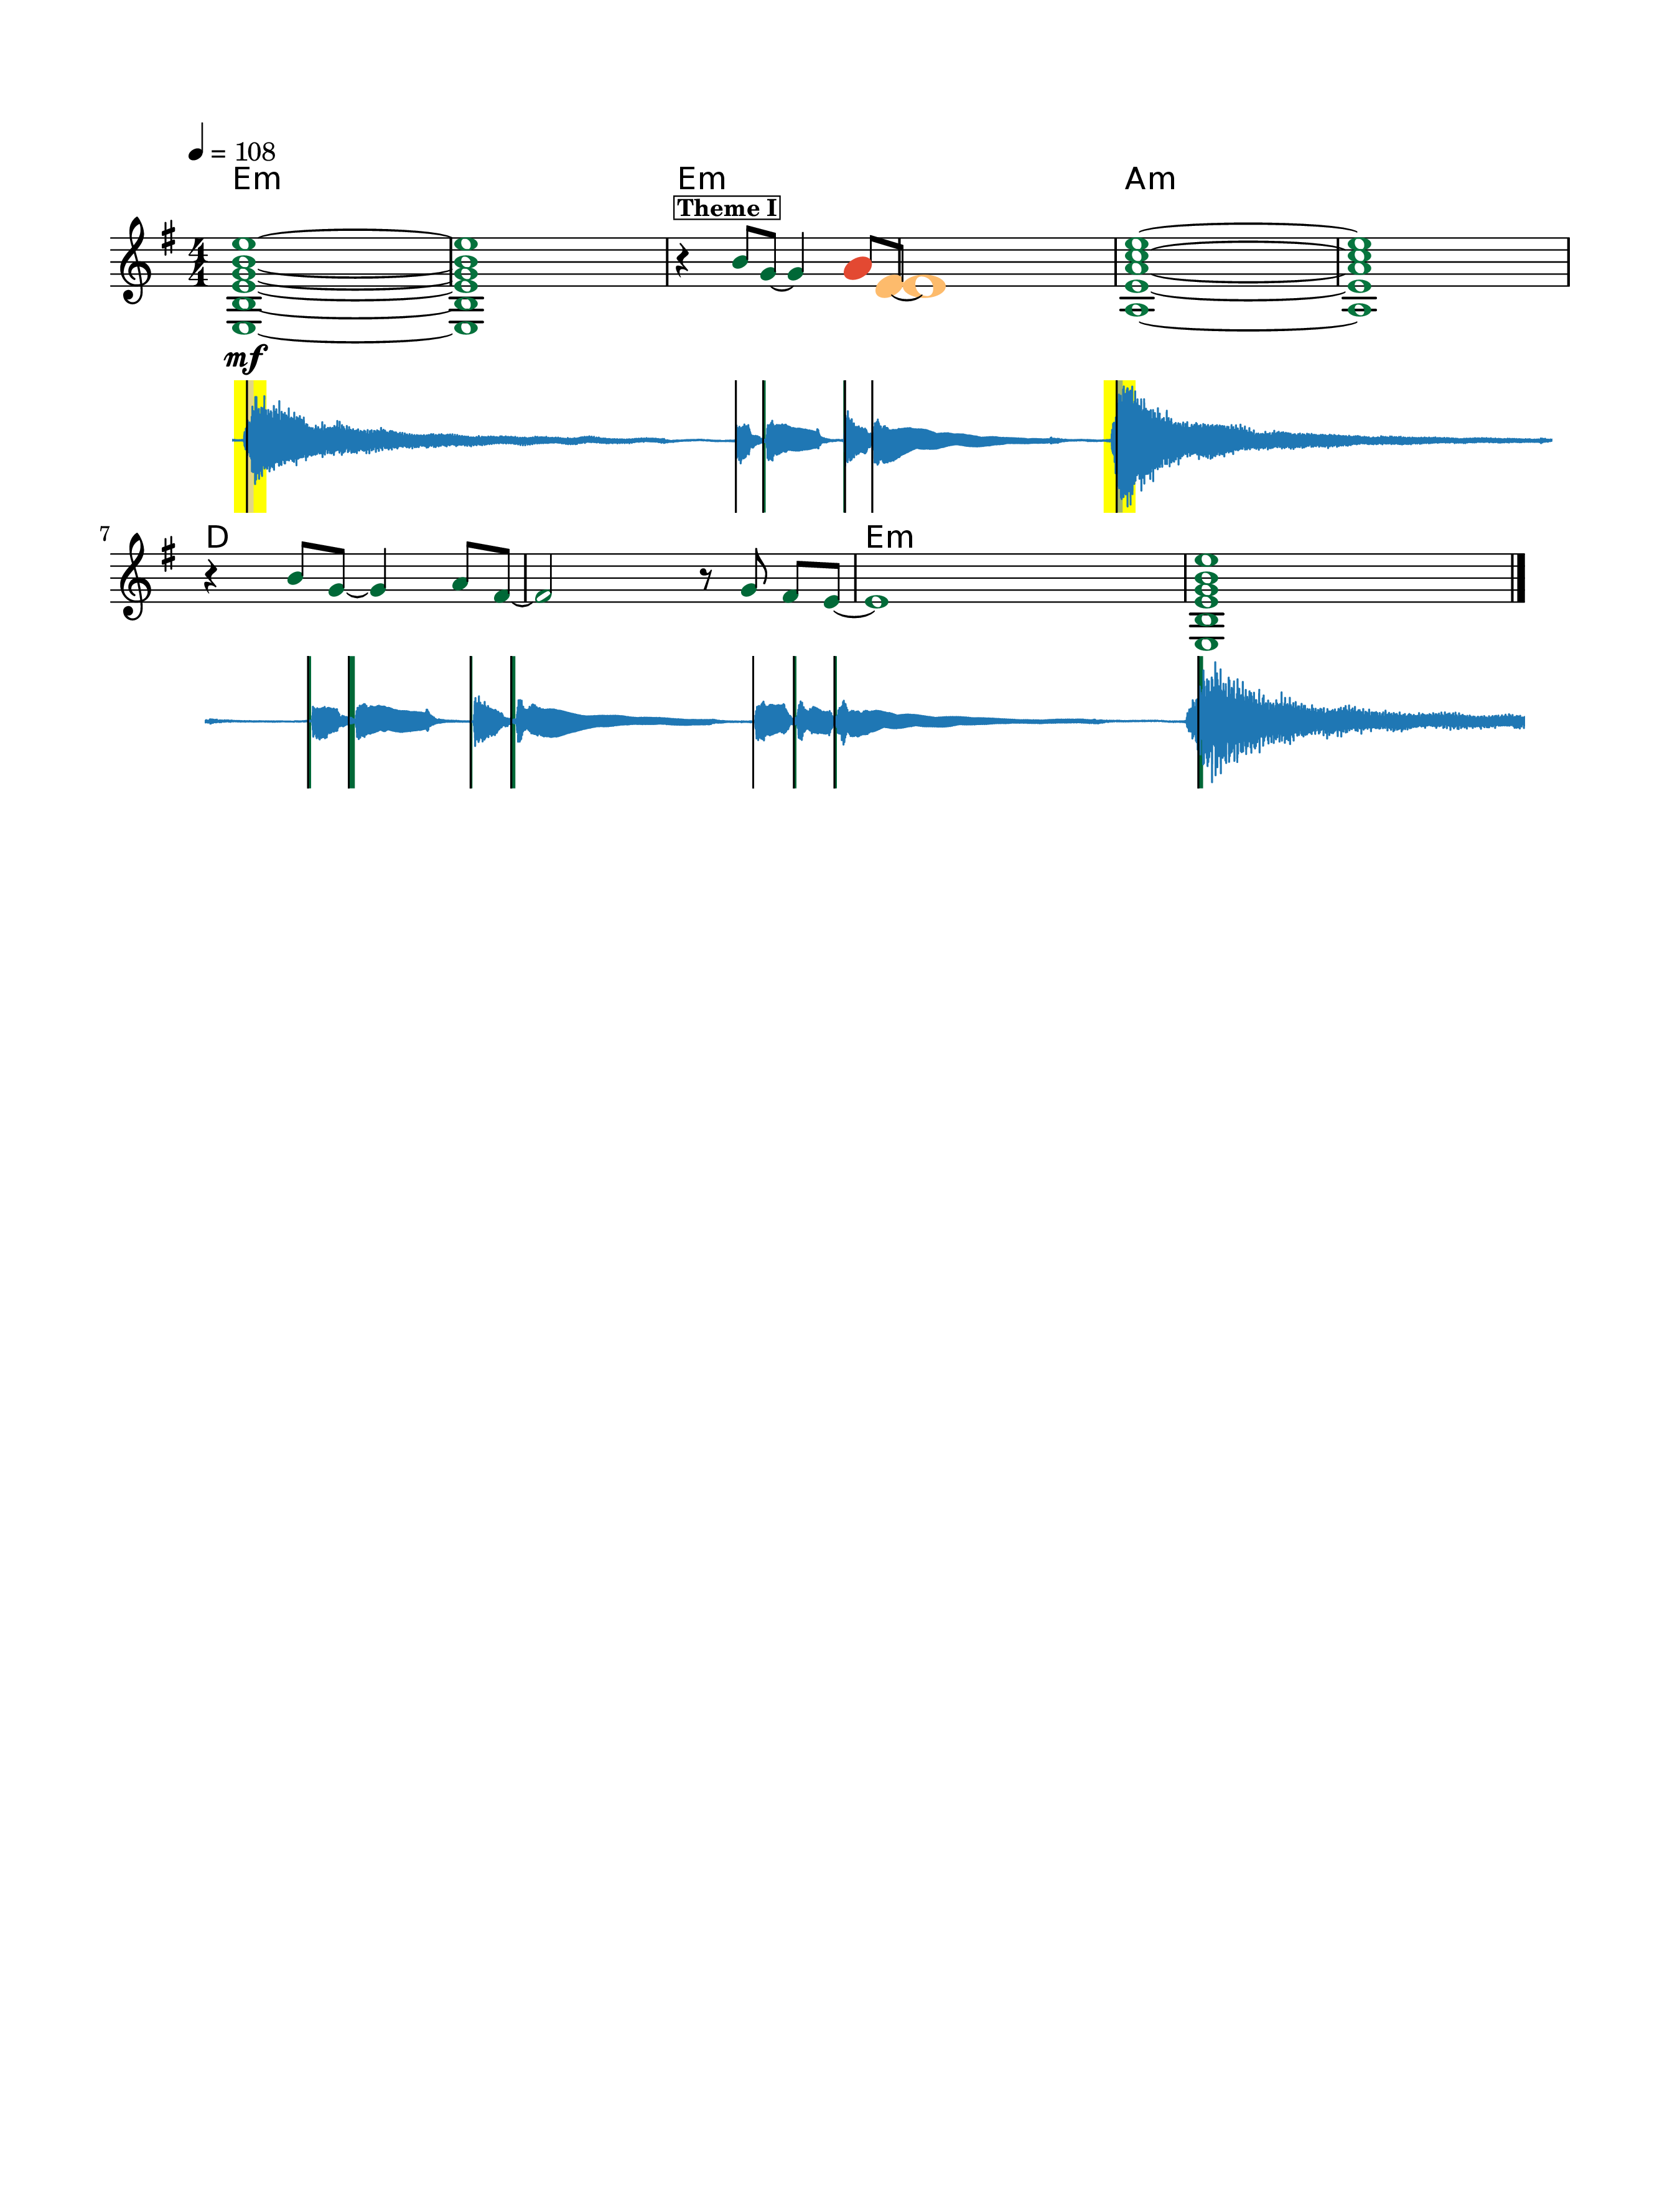

-->Rhythm variation:  0.0
-->Rhythm skewness:  8.3976
-->Chhroma variation:  0.3573
-->Chhroma skewness:  8.7324
-->Tuning variation:  0.0716
-->Tuning skewness:  3.48
-----------------------------------------------------------------------
Strumming Grades: Overall, Pitch, Rhythm, Tuning
3.0 2.0 4.0 4.0
PNG is written to Acustic_est.png
-----------------------------------------------------------------------


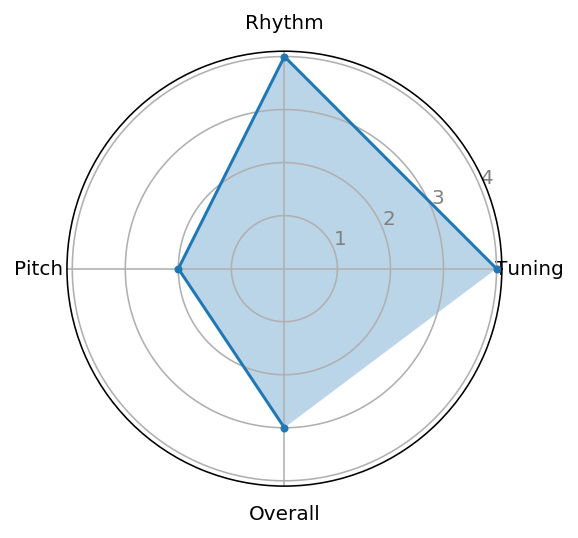

In [75]:
#---------------Stereo----------
json = data_path + 'lily_was_here.json'
target_recording = data_path +'Acustic_est.wav'
RESULT_NAME = 'Acustic_est'
global_results = Assess_Exercise(json,lilypond,target_recording,RESULT_NAME = RESULT_NAME)